# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from IPython.display import HTML
from IPython.display import display_html as displayh
import re
import os
from helper import parse_datadict, pca_results
import warnings
import random
from datetime import datetime as dt

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for encoding and clustering
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from collections import defaultdict

# ML
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

In [195]:
def display_code():
    display(HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" 
    value="Click here to toggle on/off the raw code."></form>'''))

In [2]:

class TickTock:
    """
    Automatic timer. Assign it to a variable and call the stop_clock method.
    Returns a string format '0:00:00.000000'
    """
    def __init__(self):        
        self.start_time = dt.now()
    def stop_clock(self):
        td = dt.now() - self.start_time
        return ':'.join(str(td).split(':'))

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
def display_html(message, center=False, size=20):
    if center:
        center = ';text-align: center'
    else:
        center = ''
    display(HTML('<br/><p style="font-size:{2}px; text-decoration: underline{0}">{1}<p/>'\
                 .format(center, message, size)))
    
def data_extract(file_name):
    dataframe = pd.read_csv(file_name, delimiter=';')
    print('The dataset {name} has {cols} columns and {rows:,} rows.'.format(name=file_name.split('.')[0], 
                                                                          rows=dataframe.shape[0], 
                                                                          cols=dataframe.shape[1]))
    display(HTML('<br/><p style="font-size:20px; text-decoration: underline">{} Top 5<p/>'.format(file_name.split('.')[0])))
    display(dataframe.head())
    return dataframe

In [4]:
def nan_parse(dataframe_data, dataframe_parser):
    """
    Parameters
    ----------
    dataframe_data :
    dataframe_parser :
    
    Returns: 
        Transformed np.nan dataframe at index 0
        Converted np.nan count and inpact dataframe at index 1, inpact sorted descending
    """
    
    df_unkmiss = {'ColumnName': [], 'Unk_Missing': [], 'Inpact_Percent_Parsed': []}    
    total_count = dataframe_data.shape[0]

    # go over by each column and parse
    for column in dataframe_data.columns:    

        # getting missing lists per column
        miss_unk = (dataframe_parser.loc[dataframe_parser.attribute == column, 'missing_or_unknown'])
        miss_unk = (miss_unk.item().replace('[', '').replace(']', '').split(','))

        # find the value in missing or unknown list
        flag_val_count = dataframe_data.loc[dataframe_data[column].isin(miss_unk), column].count()

        # fill in the dictionary
        if flag_val_count > 0:
            df_unkmiss['ColumnName'].append(column)
            df_unkmiss['Unk_Missing'].append(flag_val_count)
            df_unkmiss['Inpact_Percent_Parsed'].append(flag_val_count/total_count)

        # convert found missing or unknwon to np.nan
        dataframe_data.loc[dataframe_data[column].isin(miss_unk), column] = np.nan
        
    return dataframe_data, pd.DataFrame(df_unkmiss).sort_values('Inpact_Percent_Parsed', ascending=False)

In [5]:
def get_categorical(dataframe, column_list=None, show=False):
    """
    it splits the dataframes into non-categorical and categorical
    
    Parameters
    ----------
    dataframe : the dataframe to get categorical values from
    column_list : pass preferred columns or leave blank to get columns from dataframe
    show : show dataframes with categorical data to encode with the following condition:
        
        - categories with greater than 2 unique or non-numeric values
    
    Returns
    -------
    data_unencoded : this is the non-categorical data and categorical not meeting the condition
    data_toencode : this is the categorical data meeting the condition
    data_toencode : it contains the dropped columns in an array
    """
    
    display_html('Categorical Data To Encode', center=True, size=30)
    
    column_list = list(dataframe.columns)
    
    # get categorical columns only
    categorical_columns = feat_info.query("type == 'categorical' and attribute == {}".format(column_list))
    
    # getting only categorical
    data_categorical = dataframe.loc[:, categorical_columns.attribute]
    data_categorical_info = pd.concat([data_categorical.dtypes, data_categorical.nunique()], axis=1).\
                                rename(columns={0:'data_type', 1:'unique_count'}).sort_values('unique_count')
    
    if show:
        # displaying all categorical
        display_html('Categorical Descriptions')
        display(data_categorical_info)
    
    # slicing on conditions
    conditions = (data_categorical_info.data_type == object) | (data_categorical_info.unique_count > 2)    
    data_toencode_info = data_categorical_info.loc[conditions, :]
    
    if show:
        # displaying only ones meeting condition
        display_html('Features to Encode')
        display(data_toencode_info)
    
    # slicing on categories only
    data_toencode = dataframe.loc[:, data_toencode_info.index]
    
    # slicing unencoded only
    data_unencoded = dataframe.drop(data_toencode_info.index, axis=1)
    
    print('There are {} categorical variables. '\
      .format(data_categorical_info.shape[0]) +\
      '\nThere are {} categories with greater than 2 unique or non-numeric values.'\
      .format(data_toencode_info.shape[0]) +\
      '\n{} columns will be encoded.'\
      .format(data_toencode.shape[1]) +\
      '\nThe dataframe passed had {} columns in total.'\
      .format(dataframe.shape[1]) +\
      '\nThere will be {} unencoded columns.'\
      .format(dataframe.shape[1] - data_toencode.shape[1]))
    
    data_unencoded.reset_index(drop=True, inplace=True)
    
    dropped_columns = data_toencode_info.index
    
    return data_unencoded, data_toencode, dropped_columns 

In [6]:
def set_remap(dataframe, col_subset):
    # remaping keys to valuemaps
    data_dict_subset = ['value_key', 'ValueMaps']  
    
    if len(col_subset) >=15:
        print('Sample Mode')
        dataframe = dataframe.sample(n=30, random_state=42)
        
    # create container
    dataframe_return = pd.DataFrame()
    
    # for each colum passed
    for i, column in enumerate(col_subset):
        
        # provide value_key and ValueMaps of the column
        dataframe_dict_original = data_dict_view.loc[data_dict_view\
                                                        .ColumnName \
                                                        == column, 
                                                        data_dict_subset]
        
        # convert value_key to float to match passed dataframe
        dataframe_dict = dataframe_dict_original\
                                .apply(pd.to_numeric, 
                                       errors='ignore', 
                                       downcast='float')  
        
        try: # merging on floats
            # merge the passed columns from value to text, just keep text
            dataframe_merge = pd.merge(dataframe.loc[:, [column]],
                                   dataframe_dict,
                                   left_on=column,
                                   right_on='value_key',
                                   how='left'
                             ).drop(['value_key', column], axis=1)\
                              .rename(columns={'ValueMaps': column})
            
            # if merge does not bring values, keep original value key
            if dataframe_merge[column].count() == 0:
                dataframe_merge = dataframe[column].reset_index(drop=True)            
                
        except: # merging on ints
            dataframe_merge = pd.merge(dataframe.loc[:, [column]],
                                   dataframe_dict_original,
                                   left_on=column,
                                   right_on='value_key',
                                   how='left'
                             ).drop(['value_key', column], axis=1)\
                              .rename(columns={'ValueMaps': column})
        
        # if more than two col_subset is passed, concat them into one dataframe
        dataframe_return = pd.concat([dataframe_return, dataframe_merge], axis=1)
        
        
        # if dataframe_return returns nothing 
        if (dataframe_return[column].count() == 0):
            print('Ups!')
            display(dataframe[[column]].reset_index(drop=True))
        
        #if i > 42: break
        
    return dataframe_return  

In [7]:
def investigate_two(feature01, feature02):    
    display(data_dict_coldesc.query("ColumnName == '{}' \
                         or ColumnName == '{}'".format(feature01, feature02)))
    display(pd.DataFrame(feature_eng.groupby([feature01, feature02]).size()).rename(columns={0:'count'}))
    
def create_two(dataframe, feature01, feature02, feature_name='rename'):
    
    # reversing saving to spending    
    dataframe['FINAZ_AUSGEBEN'] = set_remap(dataframe, ['FINANZ_SPARER']).FINANZ_SPARER\
        .map({'very high':'very low', 'high': 'low', 'average':'average', 
              'low':'high', 'very low':'very high'})
    
    # map the data dictionary
    if 'FINAZ_AUSGEBEN' in (feature01, feature02):
        dataframe.reset_index(drop=True, inplace=True)
        feature_eng = pd.concat([set_remap(dataframe, [feature01]), dataframe.FINAZ_AUSGEBEN], axis=1)
    else:
        feature_eng = set_remap(dataframe, [feature01, feature02])
    
    # conversion visual validation
    display_html('Input Dataframe')
    if 'FINAZ_AUSGEBEN' in (feature01, feature02):
        display(dataframe[[feature01, 'FINANZ_SPARER']].head())
        print('*FINANZ_SPARER was converted to FINAZ_AUSGEBEN inversively')

        # adding description to the SPARER data values
        feature_eng.FINAZ_AUSGEBEN = feature_eng.FINAZ_AUSGEBEN.map(lambda x: str(x) + ' money-spender')
        
    else:
        display(dataframe[[feature01, feature02]].head())
        
    display_html('Mapped Dataframe')
    display(feature_eng.head())

    
    # drop FINAZ_AUSGEBEN from reference
    dataframe.drop(['FINAZ_AUSGEBEN'], axis=1, inplace=True)
    
    # create new feature
    new_feature = feature_eng.apply(lambda x: str(x[feature01]) + ' - ' + str(x[feature02]), axis=1)
    
    return pd.DataFrame(new_feature).rename(columns={0:feature_name})

In [8]:
def sweet_encode(dataframe, encoder=None):
    # setting the encoder in a dict
    if not encoder:
        encoder = defaultdict(LabelBinarizer)
    
    # dataframe container
    dataframe_encoded = pd.DataFrame()
    
    display_html('Encoding', center=True, size=30)
    # one big encoder
    for column in dataframe.columns:
        print('Endoding: %s' % column)
        X = encoder[column].fit_transform(dataframe[column].values)
        encoder_columns = [column + '_' + str(enc_value) for enc_value in range(X.shape[1])]
        new_dataframe_encoded = pd.DataFrame(X, columns=encoder_columns)
        dataframe_encoded = pd.concat([dataframe_encoded, new_dataframe_encoded], axis=1)  
    
    return dataframe_encoded, encoder

In [9]:
def set_encoding(dataframe, show=False):
    
    dataframe.reset_index(drop=True, inplace=True)    
  
    #categorical_columns = feat_info.query("type == 'categorical' and attribute == {}".format(column_list))
    
    # out of all good columns only encode ones that meet conditions
    #dataframe_toencode = dataframe.loc[:, categorical_columns.index] 
    
    # filling nulls with 0
    dataframe_toencode = dataframe.fillna('0').apply(pd.to_numeric, errors='ignore', downcast='integer')
    
    
    # dataframe container
    #dataframe_encoded = pd.DataFrame()
    
    # one big encoder    
    dataframe_encoded, encoder = sweet_encode(dataframe_toencode)
        
    # reuse dataframe_toencode
    #dataframe_toencode = dataframe.loc[:, df_encode_columns.index]
    dataframe_toencode = dataframe
    
    # get encodings in dataframe
    encoder_classes = pd.DataFrame({'encoding': 
                [encoder[column].classes_ for column in dataframe_toencode.columns]})
    
    # get null counts and datatypes merged with encdoings 
    df_toreencode = pd.concat([dataframe_toencode.isna().sum(), 
                       dataframe_toencode.dtypes], axis=1)\
                           .rename(columns={0:'Nulls', 1:'Type'})\
                           .reset_index()\
                           .rename(columns={'index':'ColumnName'})\
                           .merge(encoder_classes, left_index=True, right_index=True)
    
    # creating column label of null values to re-encode
    def f(x):
        for label in range(len(x['encoding'])):
            #print(x['encoding'])
            if str(label) == '0':
                return x['ColumnName'] + '_' + str(label)
    df_toreencode['NullLabel'] = df_toreencode.apply(lambda x: f(x), axis=1)
    
    # starting the re-encoding of null values
    pre_encode_column = df_toreencode.loc[(df_toreencode.Nulls > 0), :].ColumnName
    re_encode_column = df_toreencode.loc[(df_toreencode.Nulls > 0), :].NullLabel
    
    if show:
        display_html('Nulls Reencoded Back to Zero')
        display(df_toreencode)
    
    for pre_column, rencode_column in zip(pre_encode_column, re_encode_column):
        # get indexes to re-encode
        indexes = dataframe_toencode[[pre_column]]\
                    .loc[dataframe_toencode.isna()[pre_column]==True, :]\
                    .index
        
        # re-encoding null values from 1 to 0
        
        # get location of target column
        i = dataframe_encoded.columns.get_loc(rencode_column)

        # rencode to zero
        dataframe_encoded.iloc[indexes, i] = 0
        
    return dataframe_encoded, encoder

In [10]:
def remove_outliers(data):
    """
    removed outliers using non-parametric method IQR * 1.5
    Parameters
    ----------
    data : data with all unknown values converted to nan
    axis : 0 to removed outliers at a row level; 1 to remove, at a column level
    show : show plots
    """
    display_html('Outlier Removal Process:', center=True, size=30)
    
    # preparing dataframe of Nulls
    data_process = pd.DataFrame(data.isna().sum(), columns=['NaN_Count'])
    data_process['NaN_Impact'] = data_process.NaN_Count / data.shape[0]
    display_html('Column Removal Process', size=25)
   
    # display skewness
    display(data_process.describe())
    print('Skewness:')
    display(data_process[['NaN_Count']].skew())
    
    # REMOVING COLUMNS PROCESS    
    # getting outlier factors for non-parametric
    outlier_factor = 1.2 * (data_process.NaN_Count.quantile(.75) - data_process.NaN_Count.quantile(.25))
    median = data_process.NaN_Count.median()
    low_bound = median - outlier_factor
    high_bound = median + outlier_factor 
    
    # split bad set from good set
    column_keep = (data_process.NaN_Count >= low_bound) & (data_process.NaN_Count <= high_bound) 
    column_drop = ~column_keep[column_keep == False]
    #column_keep = list(column_keep.where(column_keep == True).dropna().index)
    
    data_process['Column_Status']\
        = data_process.NaN_Count\
            .apply(lambda x: 'Keep' if x >= int(low_bound) & x <= int(high_bound) else 'Drop')
    
    # PLOTS
    # setup subplots
    fig = plt.figure(figsize=(16, 10))  
    plt.subplots_adjust(hspace=.3)
    ax1 = plt.subplot(221)
    plt.title('Histogram of NaNs', size=14)
    ax2 = plt.subplot(223)
    plt.title('Proportion of Kept and Dropped Columns', size=14)
    ax3 = plt.subplot(122)
    plt.title('Violin Distribution of NaNs', size=14)
    
    # show plots
    sns.violinplot(y=data_process.NaN_Count, palette='Set2', inner='quart', ax=ax3)
    sns.distplot(data_process.NaN_Count, kde=False, color='green', bins=15, ax=ax1) 
    sns.countplot(x='Column_Status', data=data_process, ax=ax2)
    plt.show()  
    
    plt.figure(figsize=(16, 10))
    plt.title('Box Plot of NaNs', size=14)
    sns.boxplot(data_process.NaN_Impact)
    plt.show()
    
    # RESULTS        
    # print results to console
    print('Results from Reduction:')
    print('\tOutliers with less than {:,} or more than {:,} null count were removed.'\
          .format(low_bound, high_bound))
    print('\tOutliers with less than {:2.2%} or more than {:2.2%} impact were removed.'\
          .format(low_bound/data.shape[0], high_bound/data.shape[0]))
    print('\tThere is a total of {:,} rows and {} columns.'.format(data.shape[0], data.shape[1]))    
    print(f'\t{column_drop.shape[0]} column was/were removed.\n')
    display(pd.DataFrame(column_drop.index, columns=['Dropped List']))
    
    # show reduced histogram
    display_html('Reduced Histogram of Null Values', center=True)
    fig2 = plt.figure(figsize=(16, 10))
    ax1 = plt.subplot(221)
    sns.distplot(data_process.query("Column_Status == 'Keep'").NaN_Count, 
                 kde=False, bins=15, color='g', ax=ax1)
    ax2 = plt.subplot(222)
    sns.boxplot(data_process.query("Column_Status == 'Keep'").NaN_Impact, ax=ax2)
    plt.show()
    
    print('-'*150)
     
    return data.loc[:, column_keep]

In [11]:
def separate_row_sets(data, col_treshold=.05):
    
    # preparing dataframe of Nulls
    data_process = pd.DataFrame(data.isna().sum(axis=1), columns=['NaN_Count'])
    data_process['NaN_Impact'] = data_process.NaN_Count / data.shape[1]
    display_html('Row Removal Process', size=25)
    
    # setting treshold at a 5% of total columns
    treshold = data.shape[1] * col_treshold
    
    # getting good_set and bad_set conditions
    bad_set = data_process.NaN_Count > treshold
    good_set = ~bad_set
    
    # separating the sets
    data_process['Set_Status']\
        = data_process.NaN_Count\
            .apply(lambda x: 'bad_set' if x > treshold else 'good_set')
    
    # grouping set by Set_Status
    data_process_grp\
        = pd.DataFrame(data_process.groupby('Set_Status')\
                                        .size(), 
                                    columns=['Set_Count']).reset_index()
    data_process_grp['Set_Count_Pct'] = data_process_grp.Set_Count/data_process.shape[0]
    
    # setup subplots
    fig = plt.figure(figsize=(16, 10))  
    plt.subplots_adjust(hspace=.3)
    ax1 = plt.subplot(221)
    plt.title('Histogram of NaNs', size=14)
    ax2 = plt.subplot(223)
    plt.title('Proportion of Bad and Good Sets', size=14)
    ax3 = plt.subplot(122)
    plt.title('Violin Distribution of NaNs', size=14)
    
    # show plots
    sns.violinplot(y=data_process.NaN_Count, palette='Set2', inner='quart', ax=ax3)
    sns.distplot(data_process.NaN_Impact, kde=False, color='green', ax=ax1) 
    sns.barplot(x='Set_Status', y='Set_Count_Pct', data=data_process_grp, ax=ax2)    
    plt.show()
    
    # display skewness of plot
    display(data_process.describe())
    print('Skewness:')
    display(data_process[['NaN_Count']].skew())
    
    # display proportion numbers
    display(data_process_grp)
    
    # display dataframe with grouping by NaN_Count and Set_Status
    #display(data_process.groupby(['NaN_Count', 'Set_Status']).count().sort_values('NaN_Count'))
    
    # separating the sets
    data_good = data.loc[good_set , :] 
    data_bad = data.loc[bad_set , :]
    
    # show reduced histogram
    display_html('Reduced Histogram of Null Values', center=True)
    fig2 = plt.figure(figsize=(16, 10))
    ax1 = plt.subplot(221)
    sns.distplot(data_process.query("Set_Status == 'good_set'").NaN_Count, 
                 kde=False, color='green', bins=5, ax=ax1) 
    ax2 = plt.subplot(222)
    sns.boxplot(data_process.query("Set_Status == 'good_set'").NaN_Impact, ax=ax2)
    plt.show()
    
    print('-'*150)
    
    return data_good, data_bad

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [196]:
display_code()

In [12]:
# Load in the general demographics data.
azdias = data_extract('Udacity_AZDIAS_Subset.csv')

The dataset Udacity_AZDIAS_Subset has 85 columns and 891,221 rows.


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
# Load in the feature summary file.
feat_info = data_extract('AZDIAS_Feature_Summary.csv')

The dataset AZDIAS_Feature_Summary has 4 columns and 85 rows.


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

### 1. Data Dictionary Keys
---

In [14]:
# parse extract data dictionary
dict_colnames, dict_coldesc, dict_value_keys, dict_extra = parse_datadict()

In [15]:
# fixing value keys parsed into dict_extra due to not being numeric
temp_var = dict_extra.loc[dict_extra.key.isin(['3.6', '4.1', '4.2']), :]\
            .rename(columns={'ColumnShortName':'value_key', 'ColumnMeta':'ValueMaps'})


# if statement to only run once in the jupyter notebook
if dict_value_keys.shape[0] == 466:
    # swaping value keys
    dict_value_keys = pd.concat([dict_value_keys, temp_var]).sort_values('key')
    dict_extra.drop(temp_var.index, inplace=True)
    # cleaning extrax
    dict_extra.drop([21, 22, 55], inplace=True)

In [16]:
# completing the data dictionary for quick references to the keys and columns

# adding column short name
dict_colnames['ColumnShortName'] = dict_colnames.ColumnName.map(lambda x: x[x.find('_')+1:])

# creating dict view
data_dict_view = dict_value_keys.merge(dict_colnames, on='key', how='left')\
                                .merge(dict_coldesc, on='key', how='left')\
                                .merge(dict_extra, on='ColumnShortName', how='left')

data_dict_view.drop('key_y', axis=1, inplace=True)
data_dict_view.rename(columns={'key_x':'key'}, inplace=True)

display_html('Complete Data Dictionary View')
data_dict_view.query("ColumnName == 'FINANZ_UNAUFFAELLIGER'")

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
286,1.5,3,average,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous
292,1.5,2,high,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous
298,1.5,5,very low,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous
304,1.5,-1,unknown,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous
310,1.5,4,low,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous
316,1.5,1,very high,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,inconspicuous


### 2. Convert Missing Value Codes to NaNs
---

In [17]:
# save original copy for later use
#azdias_original = azdias.copy()

In [18]:
frame_null_original = azdias.isna().sum()
azdias_original_shape = azdias.shape
azdias_original_columns = azdias.columns

In [19]:
# Convert Missing Value Codes to NaNs
azdias, nan_parsed = nan_parse(azdias, feat_info)

In [20]:
display_html('Fisrt 5 Converted NaN View')
nan_parsed.head()

,ColumnName,Unk_Missing,Inpact_Percent_Parsed
11,TITEL_KZ,815562,0.915106
0,AGER_TYP,685843,0.769554
2,GEBURTSJAHR,392318,0.440203
19,KBA05_BAUMAX,343200,0.385090
13,ALTER_HH,236768,0.265667


In [21]:
# get original data counts and percentages in dataframe
nan_original = pd.DataFrame(frame_null_original)
nan_original.reset_index(inplace=True)
nan_original.columns = ['ColumnName', 'Original_Nan']
nan_original = nan_original.loc[nan_original.Original_Nan > 0, :]
nan_original['Inpact_Percent_Ori'] =  nan_original.Original_Nan / azdias_original_shape[0]
nan_original.sort_values('Inpact_Percent_Ori', ascending=False, inplace=True)

In [22]:
display_html('First 5 Original NaN View')
nan_original.head()

,ColumnName,Original_Nan,Inpact_Percent_Ori
47,KK_KUNDENTYP,584612,0.655967
64,KBA05_BAUMAX,133324,0.149597
63,KBA05_ANTG4,133324,0.149597
60,KBA05_ANTG1,133324,0.149597
61,KBA05_ANTG2,133324,0.149597


In [23]:
# get parsed data counts and percentages in dataframe
nan_all = pd.DataFrame(azdias.isna().sum())
nan_all.reset_index(inplace=True)
nan_all.columns = ['ColumnName', 'Nan_All']
#nan_all = nan_all.loc[nan_all.Nan_All > 0, :]
nan_all['Inpact_Percent_All'] = nan_all.Nan_All / azdias.shape[0]
nan_all.sort_values('Inpact_Percent_All', ascending=False, inplace=True)

In [24]:
display_html('First 5 Converted + Original NaN View')
nan_all.head()

,ColumnName,Nan_All,Inpact_Percent_All
40,TITEL_KZ,889061,0.997576
0,AGER_TYP,685843,0.769554
47,KK_KUNDENTYP,584612,0.655967
64,KBA05_BAUMAX,476524,0.534687
11,GEBURTSJAHR,392318,0.440203


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

### 1. Assessing Missing Data
---

In [25]:
pd.options.display.float_format = '{:.4f}'.format
# Perform an assessment of how much missing data there is in each column of the dataset
display_html('Original NaN Values Impact - Integrity Check')
display(nan_original.sum())

ColumnName            KK_KUNDENTYPKBA05_BAUMAXKBA05_ANTG4KBA05_ANTG1...
Original_Nan                                                    4896838
Inpact_Percent_Ori                                               5.4945
dtype: object

In [26]:
display_html('Parsed Unknown or Missing Values - Integrity Check')
display(nan_parsed.sum())

ColumnName               TITEL_KZAGER_TYPGEBURTSJAHRKBA05_BAUMAXALTER_H...
Unk_Missing                                                        3477091
Inpact_Percent_Parsed                                               3.9015
dtype: object

In [27]:
display_html('All NaN Count, Including Converted - Integrity Check')
display(nan_all.sum())

ColumnName            TITEL_KZAGER_TYPKK_KUNDENTYPKBA05_BAUMAXGEBURT...
Nan_All                                                         8373929
Inpact_Percent_All                                               9.3960
dtype: object

In [28]:
# combines all dataframes in one
nan_merge = pd.merge(nan_all, nan_original, how='left', on='ColumnName')
nan_merge = pd.merge(nan_merge, nan_parsed, how='left', on='ColumnName')
nan_merge.fillna(0, inplace=True)
display_html('Merged NaN Impact Analysis - Integrity Check ')
display(nan_merge.sum())

ColumnName               TITEL_KZAGER_TYPKK_KUNDENTYPKBA05_BAUMAXGEBURT...
Nan_All                                                            8373929
Inpact_Percent_All                                                  9.3960
Original_Nan                                                  4896838.0000
Inpact_Percent_Ori                                                  5.4945
Unk_Missing                                                   3477091.0000
Inpact_Percent_Parsed                                               3.9015
dtype: object

In [29]:
display_html('Merged NaN Impact Table')

# converts values to int
nan_merge.Original_Nan = nan_merge.Original_Nan.map(int)
nan_merge.Unk_Missing = nan_merge.Unk_Missing.map(int)

# get dtypes and transpose
nan_dtypes = pd.DataFrame(nan_merge.dtypes).T
nan_dtypes.rename({0: 'dtypes'}, axis='index', inplace=True)
display(nan_dtypes, nan_merge)

,ColumnName,Nan_All,Inpact_Percent_All,Original_Nan,Inpact_Percent_Ori,Unk_Missing,Inpact_Percent_Parsed
dtypes,object,int64,float64,int64,float64,int64,float64


,ColumnName,Nan_All,Inpact_Percent_All,Original_Nan,Inpact_Percent_Ori,Unk_Missing,Inpact_Percent_Parsed
0,TITEL_KZ,889061,0.9976,73499,0.0825,815562,0.9151
1,AGER_TYP,685843,0.7696,0,0.0000,685843,0.7696
2,KK_KUNDENTYP,584612,0.6560,584612,0.6560,0,0.0000
3,KBA05_BAUMAX,476524,0.5347,133324,0.1496,343200,0.3851
4,GEBURTSJAHR,392318,0.4402,0,0.0000,392318,0.4402
5,ALTER_HH,310267,0.3481,73499,0.0825,236768,0.2657
6,KKK,158064,0.1774,121196,0.1360,36868,0.0414
7,REGIOTYP,158064,0.1774,121196,0.1360,36868,0.0414
8,W_KEIT_KIND_HH,147988,0.1661,107602,0.1207,40386,0.0453
9,KBA05_ANTG1,133324,0.1496,133324,0.1496,0,0.0000


In [30]:
# descriptive statistics about all nan datasets, original, parsed, and all
display_html('Descriptive Statistics of Original NaN, Unknown or Missing')
nan_descript = nan_merge.loc[nan_merge.Nan_All > 0, :].describe()
nan_descript

,Nan_All,Inpact_Percent_All,Original_Nan,Inpact_Percent_Ori,Unk_Missing,Inpact_Percent_Parsed
count,61.0000,61.0000,61.0000,61.0000,61.0000,61.0000
mean,137277.5246,0.1540,80276.0328,0.0901,57001.4918,0.0640
std,157099.4964,0.1763,82088.4548,0.0921,150405.2112,0.1688
min,2881.0000,0.0032,0.0000,0.0000,0.0000,0.0000
25%,93148.0000,0.1045,4854.0000,0.0054,0.0000,0.0000
50%,99352.0000,0.1115,93148.0000,0.1045,0.0000,0.0000
75%,116515.0000,0.1307,116515.0000,0.1307,36868.0000,0.0414
max,889061.0000,0.9976,584612.0000,0.6560,815562.0000,0.9151


### 2. Outlier Detection and Removal
---

,NaN_Count,NaN_Impact
count,85.0000,85.0000
mean,98516.8118,0.1105
std,146604.2033,0.1645
min,0.0000,0.0000
25%,0.0000,0.0000
50%,93148.0000,0.1045
75%,116515.0000,0.1307
max,889061.0000,0.9976


Skewness:


NaN_Count   3.3734
dtype: float64

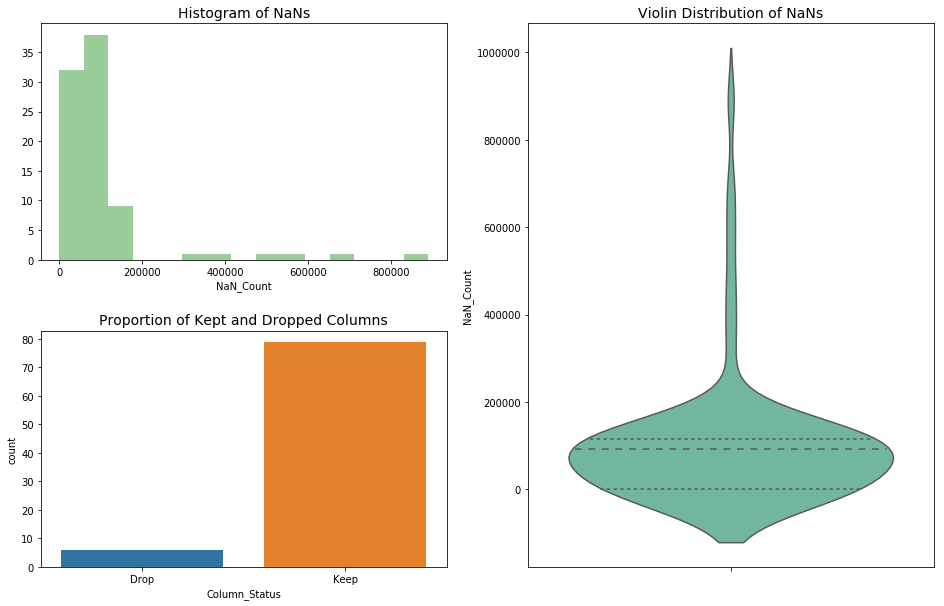

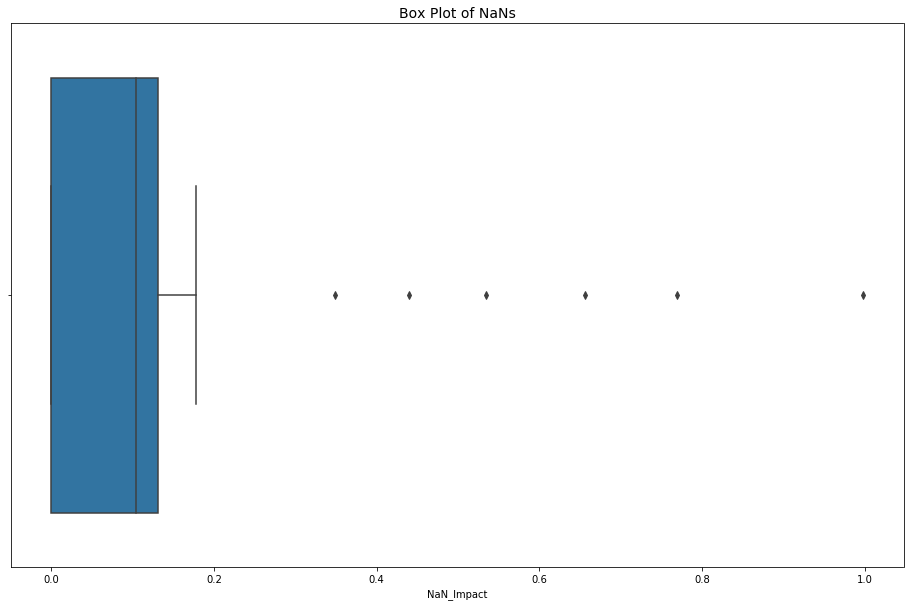

Results from Reduction:
	Outliers with less than -46,670.0 or more than 232,966.0 null count were removed.
	Outliers with less than -5.24% or more than 26.14% impact were removed.
	There is a total of 891,221 rows and 85 columns.
	6 column was/were removed.



,Dropped List
0,AGER_TYP
1,GEBURTSJAHR
2,TITEL_KZ
3,ALTER_HH
4,KK_KUNDENTYP
5,KBA05_BAUMAX


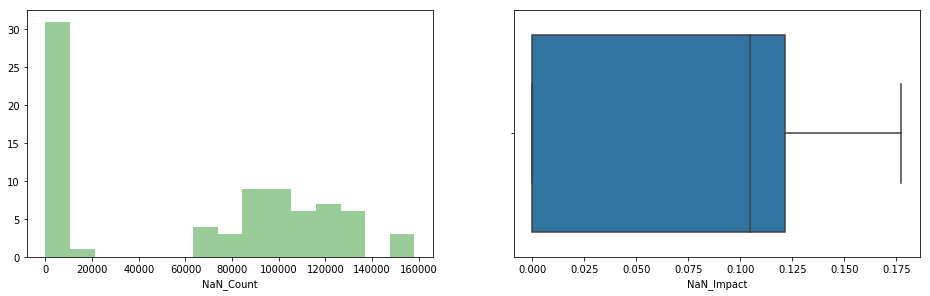

------------------------------------------------------------------------------------------------------------------------------------------------------


In [31]:
# removing outliers
frame_ager_type_subset = azdias[['ALTERSKATEGORIE_GROB', 'AGER_TYP']]
azdias = remove_outliers(azdias)

In [32]:
print('There were %s columns removed.' % (len(azdias_original_columns) - len(azdias.columns)))

There were 6 columns removed.


In [33]:
pd.options.display.max_rows = 100
data_dict_coldesc = pd.merge(dict_colnames, dict_coldesc, on='key', how='left')

# columns kept
data_dict_coldesc['Kept'] = data_dict_coldesc.ColumnName.apply(lambda x: x in azdias.columns)

# adding data types
data_dict_coldesc = data_dict_coldesc.merge(feat_info.loc[:, ['attribute', 'type']], 
                                            left_on='ColumnName', 
                                            right_on='attribute', 
                                            how='left')\
                                     .drop('attribute', axis=1)

# adding column type for columns kept
display_html('Columns Kept for Analysis with Description')
data_dict_coldesc.loc[data_dict_coldesc.Kept == True, :]
        

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
1,1.2,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,True,ordinal
2,1.3,ANREDE_KZ,KZ,Gender,True,categorical
3,1.4,CJT_GESAMTTYP,GESAMTTYP,Customer-Journey-Typology: preferred informati...,True,categorical
4,1.5,FINANZ_MINIMALIST,MINIMALIST,Financial typology,True,ordinal
5,1.5,FINANZ_SPARER,SPARER,Financial typology,True,ordinal
6,1.5,FINANZ_VORSORGER,VORSORGER,Financial typology,True,ordinal
7,1.5,FINANZ_ANLEGER,ANLEGER,Financial typology,True,ordinal
8,1.5,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,True,ordinal
9,1.5,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,True,ordinal
10,1.6,FINANZTYP,FINANZTYP,Most descriptive financial type for individual,True,categorical


In [34]:
# showing columns removed
display_html('Columns Removed from Analysis with Description')
df_removed_cols = data_dict_coldesc.loc[~data_dict_coldesc.Kept == True, ['key', 'ColumnName', 'ColNameDescription']]
df_removed_cols

,key,ColumnName,ColNameDescription
0,1.1,AGER_TYP,Best-ager typology
11,1.7,GEBURTSJAHR,Year of birth
40,1.23,TITEL_KZ,Academic title flag
43,2.1,ALTER_HH,Birthdate of head of household
47,2.5,KK_KUNDENTYP,Consumer pattern over past 12 months
64,5.5,KBA05_BAUMAX,Most common building type within the microcell


In [35]:
# removed data in context
data_dict_view.loc[data_dict_view.key.isin(df_removed_cols.key), :]

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
0,1.1,-1,unknown,AGER_TYP,TYP,Best-ager typology,NaN
1,1.1,0,no classification possible,AGER_TYP,TYP,Best-ager typology,NaN
2,1.1,1,passive elderly,AGER_TYP,TYP,Best-ager typology,NaN
3,1.1,2,cultural elderly,AGER_TYP,TYP,Best-ager typology,NaN
4,1.1,3,experience-driven elderly,AGER_TYP,TYP,Best-ager typology,NaN
253,1.23,4,Prof. Dr.,TITEL_KZ,KZ,Academic title flag,NaN
254,1.23,-1,unknown,TITEL_KZ,KZ,Academic title flag,NaN
255,1.23,0,unknown,TITEL_KZ,KZ,Academic title flag,NaN
256,1.23,5,other,TITEL_KZ,KZ,Academic title flag,NaN
257,1.23,1,Dr.,TITEL_KZ,KZ,Academic title flag,NaN


In [36]:
display_html('Exploring AGER_TYP using ALTERSKATEGORIE_GROB')
col_subset = ['ALTERSKATEGORIE_GROB', 'AGER_TYP']
ager_typ = set_remap(frame_ager_type_subset, col_subset)
ager_typ.loc[~ager_typ.AGER_TYP.isna(), col_subset].groupby(col_subset).size()

ALTERSKATEGORIE_GROB  AGER_TYP                 
30 - 45 years old     cultural elderly               110
                      experience-driven elderly     5641
                      passive elderly                178
46 - 60 years old     cultural elderly             24198
                      experience-driven elderly    15921
                      passive elderly              27743
< 30 years old        cultural elderly               823
                      experience-driven elderly     4906
                      passive elderly               1058
> 60 years old        cultural elderly             73189
                      experience-driven elderly      339
                      passive elderly              50728
dtype: int64

#### Discussion 1.1.2: Assess Missing Data in Each Column

>Missing data after combining what was already NaN from the raw csv data and the mappings in the information data csv was up to 99.76% and at least 0.32%. Mostly NaN values came from mapping missing or unknwon values to the feat info dataset, which shows the numerical maps of missing or unknown values.

>Most of the missing data relates to academic titles, birthdates, building types and a colum appearing to describe some elderly personal character typology. However, the data in this column seems to not describe what was intended since people younger than 30 are labeled as elderly. They might have stopped getting this data at some point.

> The columns droped were 
['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [37]:
try: 
    nan_descript.Unk_Missing = nan_descript.Unk_Missing.map('{:0,.2f}'.format)
    nan_descript.Original_Nan = nan_descript.Original_Nan.map('{:0,.2f}'.format)
    nan_descript.Nan_All = nan_descript.Nan_All.map('{:0,.2f}'.format)
except:pass

nan_descript

,Nan_All,Inpact_Percent_All,Original_Nan,Inpact_Percent_Ori,Unk_Missing,Inpact_Percent_Parsed
count,61.00,61.0000,61.00,61.0000,61.00,61.0000
mean,"137,277.52",0.1540,"80,276.03",0.0901,"57,001.49",0.0640
std,"157,099.50",0.1763,"82,088.45",0.0921,"150,405.21",0.1688
min,"2,881.00",0.0032,0.00,0.0000,0.00,0.0000
25%,"93,148.00",0.1045,"4,854.00",0.0054,0.00,0.0000
50%,"99,352.00",0.1115,"93,148.00",0.1045,0.00,0.0000
75%,"116,515.00",0.1307,"116,515.00",0.1307,"36,868.00",0.0414
max,"889,061.00",0.9976,"584,612.00",0.6560,"815,562.00",0.9151


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [38]:
def get_good_bad_targets(dataframe):
 
    count_null = pd.concat([dataframe.isna().sum(), dataframe.count()], 
                     axis=1).rename(columns={0:'Null', 1:'Count'})
    
    df_count = count_null.query("Count/Null > .1")    
    sty_count = df_count.style\
        .set_table_attributes("style='display:inline'")\
        .set_caption("Table with Values")

    df_null = count_null.query("Count/Null <= .1")    
    sty_null = df_null.style\
        .set_table_attributes("style='display:inline'")\
        .set_caption("Table with No or Few Values")
    
    displayh(sty_count._repr_html_() + sty_null._repr_html_() , raw=True)
    column_sample = random.sample(list(df_count.index), 8)
    
    return column_sample

In [39]:
def plot_good_bad(good_data, bad_data, target):
    
    fig = plt.figure(figsize=(16, 30))
    subplots = [good_data.loc[:, target], bad_data.loc[:, target]]
    plot_id = 1

    display_html('Good Set Vs. Bad Set Data Distributions', 20)
    for i, column in enumerate(target, 1):    
        for j, subplot in enumerate(subplots):        
            fig.add_subplot(8, 2, plot_id)
            sns.countplot(x = column, data=subplot)        
            plot_id += 1

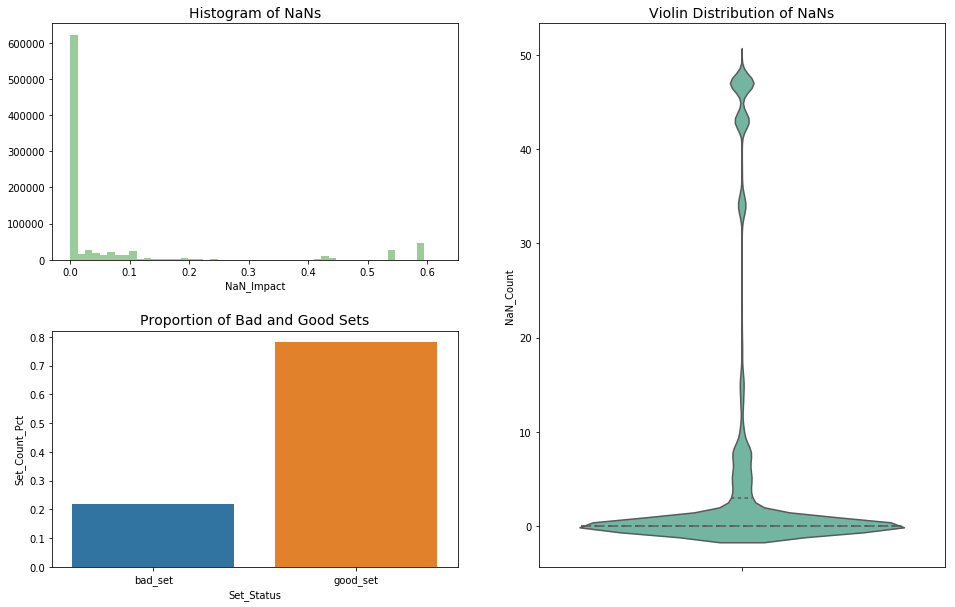

,NaN_Count,NaN_Impact
count,891221.0000,891221.0000
mean,5.6499,0.0715
std,13.2347,0.1675
min,0.0000,0.0000
25%,0.0000,0.0000
50%,0.0000,0.0000
75%,3.0000,0.0380
max,49.0000,0.6203


Skewness:


NaN_Count   2.4493
dtype: float64

,Set_Status,Set_Count,Set_Count_Pct
0,bad_set,194112,0.2178
1,good_set,697109,0.7822


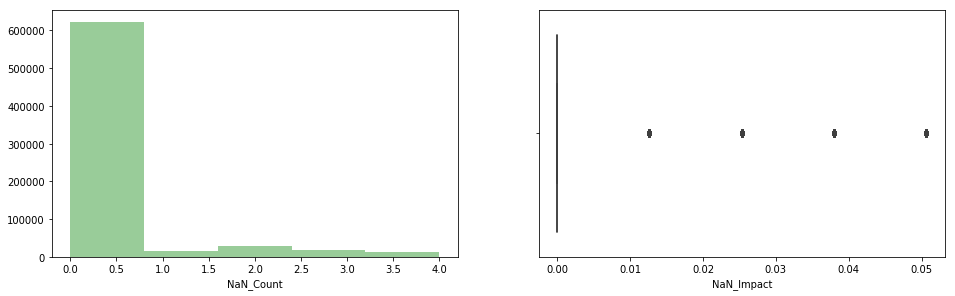

------------------------------------------------------------------------------------------------------------------------------------------------------


In [40]:
azdias_good, azdias_bad = separate_row_sets(azdias, col_treshold=.06)

In [41]:
# arbitrary target columns
target_columns = ['ANREDE_KZ', 'PLZ8_BAUMAX', 'GFK_URLAUBERTYP', 'WOHNLAGE',
       'KBA05_ANTG2', 'RETOURTYP_BK_S', 'FINANZ_ANLEGER',
       'PRAEGENDE_JUGENDJAHRE']

,Null,Count
ALTERSKATEGORIE_GROB,1464,192648
ANREDE_KZ,0,194112
CJT_GESAMTTYP,4854,189258
FINANZ_MINIMALIST,0,194112
FINANZ_SPARER,0,194112
FINANZ_VORSORGER,0,194112
FINANZ_ANLEGER,0,194112
FINANZ_UNAUFFAELLIGER,0,194112
FINANZ_HAUSBAUER,0,194112
FINANZTYP,0,194112


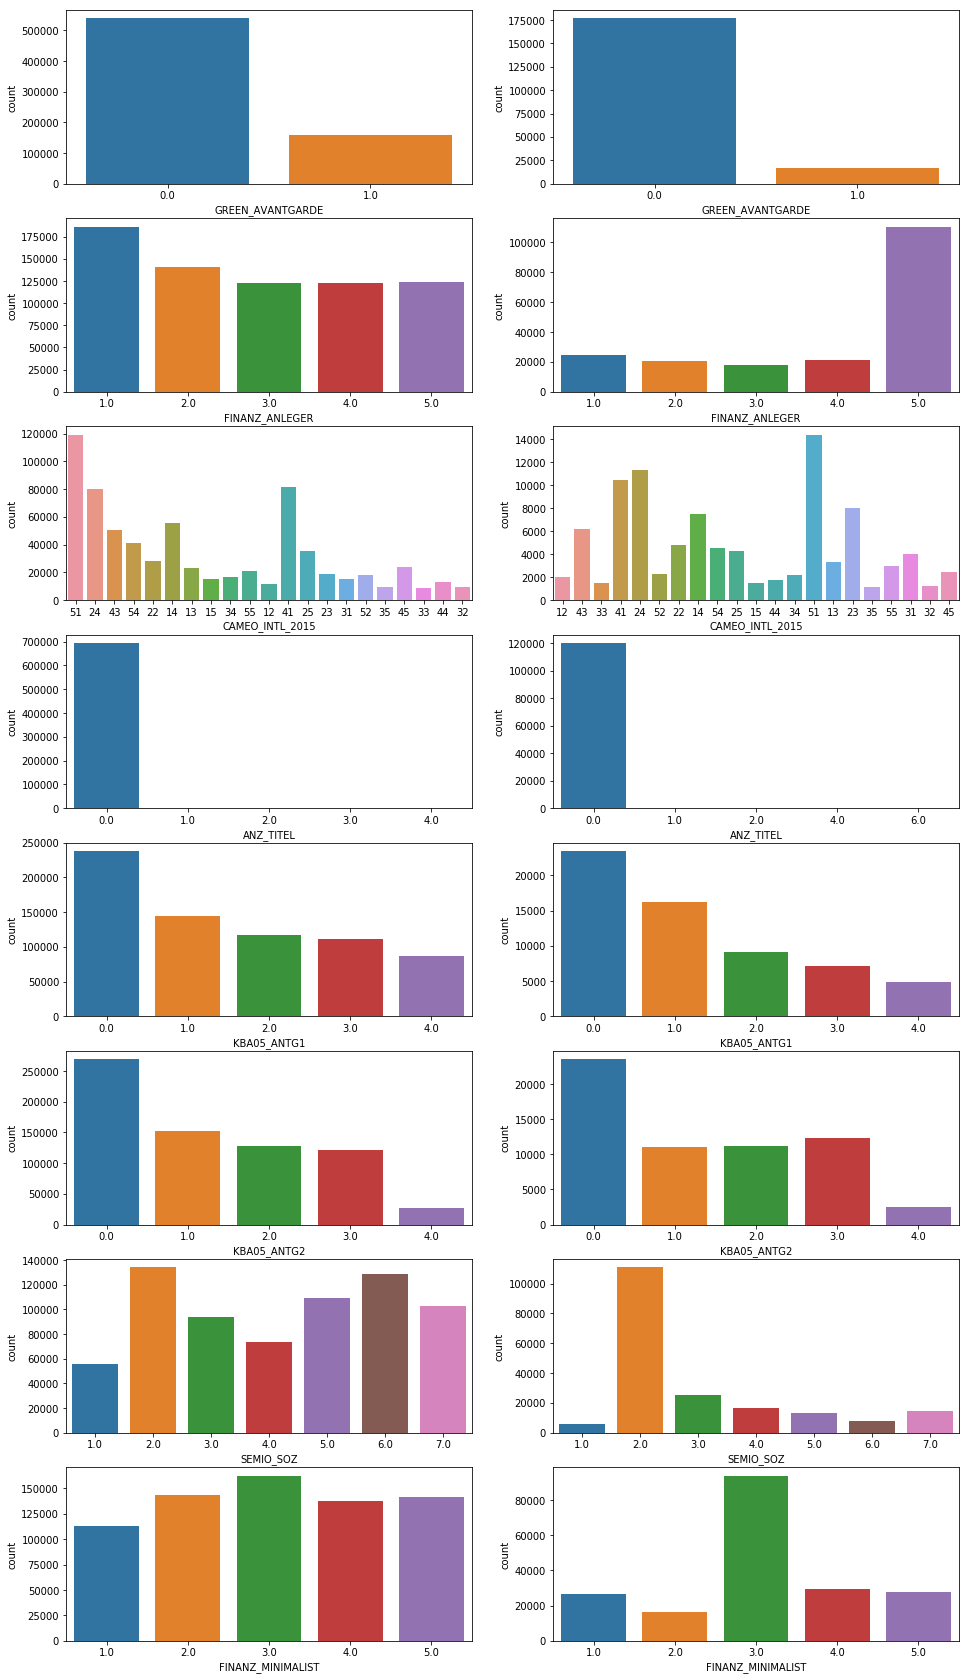

In [42]:
target_columns = get_good_bad_targets(azdias_bad)
plot_good_bad(azdias_good, azdias_bad, target_columns)

In [43]:
data_dict_view.query("ColumnName=='KBA05_ANTG2'")

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
496,5.2,-1,unknown,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN
497,5.2,0,no 3-5 family homes,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN
498,5.2,1,lower share of 3-5 family homes,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN
499,5.2,2,average share of 3-5 family homes,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN
500,5.2,3,high share of 3-5 family homes,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN
501,5.2,4,very high share of 3-5 family homes,KBA05_ANTG2,ANTG2,Number of 3-5 family houses in the microcell,NaN


#### Discussion 1.1.3: Assess Missing Data in Each Row

> There were many rows with more than the interquartile range * 1.5. These rows where separated and put in the bad dataset. The distribution of values between the good and bad set was not too different. Robustly, they are quite similar in some aspects. Some examples where data differences differe where in GFK_URLAUBERTYP. Value 5 or Nature fans was significantly higher in the bad set. However, the distribution followed almoust the same shape. In general, I think we can continue with the good set for the analysis as they are robustly similar. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [44]:
# How many features are there of each data type?
display_html('Features per Datatype')
pd.DataFrame(feat_info.groupby('type').size()).reset_index().rename(columns={0:'col_count'})

,type,col_count
0,categorical,21
1,interval,1
2,mixed,7
3,numeric,7
4,ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

### 1. Validating Sets
---

In [45]:
print(
    'Original Data:', azdias_original_shape,
    '\nReduced Column Data:', azdias.shape,
    '\nReduced Rows Data:', azdias_good.shape,
    '\nBad Row Data:', azdias_bad.shape,
    '\nGood + Bad Row Data:', azdias_good.shape[0] + azdias_bad.shape[0])

Original Data: (891221, 85) 
Reduced Column Data: (891221, 79) 
Reduced Rows Data: (697109, 79) 
Bad Row Data: (194112, 79) 
Good + Bad Row Data: 891221


### 2. Assessing Categorical Data to Encode
---

In [46]:
display_html('Categorical Columns to Encode')
categorical_columns = data_dict_coldesc.query("type == 'categorical' and Kept == True")
display(categorical_columns)

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
2,1.3,ANREDE_KZ,KZ,Gender,True,categorical
3,1.4,CJT_GESAMTTYP,GESAMTTYP,Customer-Journey-Typology: preferred informati...,True,categorical
10,1.6,FINANZTYP,FINANZTYP,Most descriptive financial type for individual,True,categorical
12,1.8,GFK_URLAUBERTYP,URLAUBERTYP,Vacation habits,True,categorical
13,1.9,GREEN_AVANTGARDE,AVANTGARDE,Membership in environmental sustainability as ...,True,categorical
17,1.13,LP_FAMILIE_FEIN,FAMILIE_FEIN,Family type,True,categorical
18,1.14,LP_FAMILIE_GROB,FAMILIE_GROB,Family type,True,categorical
19,1.15,LP_STATUS_FEIN,STATUS_FEIN,Social status,True,categorical
20,1.16,LP_STATUS_GROB,STATUS_GROB,Social status,True,categorical
21,1.17,NATIONALITAET_KZ,KZ,Nationality based on given name analysis,True,categorical


### 3. Get Categorical and Encode
---

In [47]:
azdias_unencoded, azdias_toencode, dropped_columns = get_categorical(azdias_good, show=True)

,data_type,unique_count
ANREDE_KZ,float64,2
OST_WEST_KZ,object,2
VERS_TYP,float64,2
SOHO_KZ,float64,2
GREEN_AVANTGARDE,float64,2
NATIONALITAET_KZ,float64,3
SHOPPER_TYP,float64,4
LP_STATUS_GROB,float64,5
LP_FAMILIE_GROB,float64,5
FINANZTYP,float64,6


,data_type,unique_count
OST_WEST_KZ,object,2
NATIONALITAET_KZ,float64,3
SHOPPER_TYP,float64,4
LP_STATUS_GROB,float64,5
LP_FAMILIE_GROB,float64,5
FINANZTYP,float64,6
ZABEOTYP,float64,6
CJT_GESAMTTYP,float64,6
GEBAEUDETYP,float64,7
CAMEO_DEUG_2015,object,9


There are 18 categorical variables. 
There are 14 categories with greater than 2 unique or non-numeric values.
14 columns will be encoded.
The dataframe passed had 79 columns in total.
There will be 65 unencoded columns.


In [48]:
azdias_encoded, encoder = set_encoding(azdias_toencode, show=True)
display_html('Data Encoded:')
azdias_encoded.head(30)

Endoding: OST_WEST_KZ
Endoding: NATIONALITAET_KZ
Endoding: SHOPPER_TYP
Endoding: LP_STATUS_GROB
Endoding: LP_FAMILIE_GROB
Endoding: FINANZTYP
Endoding: ZABEOTYP
Endoding: CJT_GESAMTTYP
Endoding: GEBAEUDETYP
Endoding: CAMEO_DEUG_2015
Endoding: LP_STATUS_FEIN
Endoding: LP_FAMILIE_FEIN
Endoding: GFK_URLAUBERTYP
Endoding: CAMEO_DEU_2015


,ColumnName,Nulls,Type,encoding,NullLabel
0,OST_WEST_KZ,0,object,"[O, W]",OST_WEST_KZ_0
1,NATIONALITAET_KZ,10834,float64,"[0, 1, 2, 3]",NATIONALITAET_KZ_0
2,SHOPPER_TYP,12251,float64,"[0, 1, 2, 3]",SHOPPER_TYP_0
3,LP_STATUS_GROB,0,float64,"[1, 2, 3, 4, 5]",LP_STATUS_GROB_0
4,LP_FAMILIE_GROB,0,float64,"[1, 2, 3, 4, 5]",LP_FAMILIE_GROB_0
5,FINANZTYP,0,float64,"[1, 2, 3, 4, 5, 6]",FINANZTYP_0
6,ZABEOTYP,0,float64,"[1, 2, 3, 4, 5, 6]",ZABEOTYP_0
7,CJT_GESAMTTYP,0,float64,"[1, 2, 3, 4, 5, 6]",CJT_GESAMTTYP_0
8,GEBAEUDETYP,0,float64,"[1, 2, 3, 4, 5, 6, 8]",GEBAEUDETYP_0
9,CAMEO_DEUG_2015,2841,object,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",CAMEO_DEUG_2015_0


,OST_WEST_KZ_0,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,LP_STATUS_GROB_0,...,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_44
0,1,0,1,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
9,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4. Validating Encodied Nulls Re-set to 0
---

In [49]:
display_html('Validation on NATIONALITAET_KZ Where NATIONALITAET_KZ is Null')
null_valid = azdias_encoded[['NATIONALITAET_KZ_0', 
                             'NATIONALITAET_KZ_1', 
                             'NATIONALITAET_KZ_2', 
                             'NATIONALITAET_KZ_3']]\
                .merge(azdias_good[['NATIONALITAET_KZ']]\
                .reset_index(drop=True), left_index=True, right_index=True)\
                .query("NATIONALITAET_KZ != NATIONALITAET_KZ")
display(null_valid.head())
print('Non-null values in the frame: \n%s' % null_valid.sum())

,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,NATIONALITAET_KZ
19,0,0,0,0,nan
39,0,0,0,0,nan
57,0,0,0,0,nan
92,0,0,0,0,nan
198,0,0,0,0,nan


Non-null values in the frame: 
NATIONALITAET_KZ_0   0.0000
NATIONALITAET_KZ_1   0.0000
NATIONALITAET_KZ_2   0.0000
NATIONALITAET_KZ_3   0.0000
NATIONALITAET_KZ     0.0000
dtype: float64


### 5. Combining Unencoded with Encoded Columns
---

In [50]:
azdias_toencode.index

RangeIndex(start=0, stop=697109, step=1)

In [51]:
azdias_encoded.index

RangeIndex(start=0, stop=697109, step=1)

In [52]:
azdias_unencoded.index

RangeIndex(start=0, stop=697109, step=1)

In [53]:
print(f'Azdias has {len(azdias_original_columns)} columns.'+\
      f'\nEncoding created {len(azdias_encoded.columns)} columns.'+\
      f'Azdias was reduced to {len(azdias_good.columns)} columns')

# combining dataframes
azdias = pd.concat([azdias_unencoded, azdias_encoded], axis=1)

print(f'Azdias total columns are {len(azdias.columns)}'+\
      f'\n\nAzdias encoding is completed. {len(dropped_columns)}'+\
       ' repeated columns were dropped due to encoding.'+\
       '\nAzdias total columns before drop of repeated columns '+\
      f'after feature engeniering {str(azdias.shape[1] + len(dropped_columns))}')


Azdias has 85 columns.
Encoding created 132 columns.Azdias was reduced to 79 columns
Azdias total columns are 197

Azdias encoding is completed. 14 repeated columns were dropped due to encoding.
Azdias total columns before drop of repeated columns after feature engeniering 211


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

> After finding all categorical and mixed variables, I found several of them meeting unique value counts of 2, which does not require encoding. One of those was actually an object type column, thus not numeric. So I flag OST_WEST_KZ to be encoded. The following list needed to be encoded: ['OST_WEST_KZ', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB',
       'LP_FAMILIE_GROB', 'FINANZTYP', 'ZABEOTYP', 'CJT_GESAMTTYP',
       'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN',
       'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']
       
>I used the LabelBinarizer to encode since it does Label Encoding and Hot Encoding at the same time. But then I encounter errors due to Null values. Since there were not 0 labels left as they where all converted to numpy nan, I filled null values with 0 to be able to run the encoder. Two categorical/mixed colums did not have any nulls: FINANZTYP and ZABEOTYP.

> After encoding the categorical values. I re-encoded the 0 labels for Null values that where encoded as 1 back to 0 using indexes of the original data. Null values where validated by comparing the sum of null values on the original data vs the encoded data and compared again at a row level using the original data as well.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1. Validating Data Progression
---

In [54]:
print(f'Original Azdias Shape: {azdias_original_shape}'+
      f'\nEncoded Frame Shape: {azdias_encoded.shape}'+
      f'\nGood set Shape: {azdias_good.shape}'+
      f'\nTo-encode Categorial Shape: {azdias_toencode.shape}'+
      f'\nUencoded Shape: {azdias_unencoded.shape}'+
      f'\nUencoded + Encoded Shape: {azdias.shape}')

Original Azdias Shape: (891221, 85)
Encoded Frame Shape: (697109, 132)
Good set Shape: (697109, 79)
To-encode Categorial Shape: (697109, 14)
Uencoded Shape: (697109, 65)
Uencoded + Encoded Shape: (697109, 197)


### 2. Assessing Mixed-Type Features
---

In [55]:
display_html('Mixed Type Features')
data_dict_coldesc.query("type == 'mixed'")

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
15,1.11,LP_LEBENSPHASE_FEIN,LEBENSPHASE_FEIN,Life stage,True,mixed
16,1.12,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,True,mixed
22,1.18,PRAEGENDE_JUGENDJAHRE,JUGENDJAHRE,Dominating movement of person's youth (avantga...,True,mixed
56,3.7,WOHNLAGE,WOHNLAGE,Neighborhood quality (or rural flag),True,mixed
59,4.3,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,True,mixed
64,5.5,KBA05_BAUMAX,BAUMAX,Most common building type within the microcell,False,mixed
79,8.6,PLZ8_BAUMAX,BAUMAX,Most common building type within the PLZ8 region,True,mixed


### 3. Remaping Value Keys to Data Dictionary and Investigating/Engineering New Features
---

In [56]:
#pd.options.display.max_rows = 20
col_subset = ['PRAEGENDE_JUGENDJAHRE', 'RELAT_AB']
column_names = list(data_dict_coldesc.query("type == 'mixed' and Kept == True").ColumnName)
colum_additions = list(data_dict_coldesc.query("type != 'mixed' and ColNameDescription == 'Financial typology'").ColumnName)
feature_eng = set_remap(azdias, column_names + colum_additions)

In [57]:
feature_eng.head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER
0,single parent low-income earners,single parents,90s - digital media kids (Mainstream,poor neighborhood,Poorer Households - Pre-Family Couples & Singles,mainly 1-2 family homes,very high,very low,high,very low,low,very low
1,single average earners of younger age,single low-income and average earners of young...,90s - ecological awareness (Avantgarde,good neighborhood,Prosperous Households - Older Families & Matur...,mainly 1-2 family homes,very high,low,very high,high,average,very low
2,NaN,low-income and average earners of higher age f...,70s - family orientation (Mainstream,average neighborhood,Less Affluent Households - Families With Schoo...,mainly 3-5 family homes,low,average,low,very high,average,high
3,single average earners at retirement age,single low-income and average earners of highe...,50s - economic miracle (Mainstream,rural neighborhood,Poorer Households - Older Families & Mature Co...,mainly 1-2 family homes,average,very high,very low,high,high,very low
4,single low-income earners of middle age,single low-income and average earners of young...,80s - Generation Golf (Mainstream,very poor neighborhood,Prosperous Households - Young Couples With Chi...,mainly 1-2 family homes,very high,very low,very high,very low,low,average


#### 3.1 Ivestigating New Feature 01 

> Life Style of Neiborhood and type of Spending

In [58]:
display_html('Financial Typology Descriptions')
data_dict_coldesc.query("type != 'mixed' and ColNameDescription == 'Financial typology'")\
        .merge(dict_extra[['ColumnShortName', 'ColumnMeta']], on='ColumnShortName', how='left')

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type,ColumnMeta
0,1.5,FINANZ_MINIMALIST,MINIMALIST,Financial typology,True,ordinal,low financial interest
1,1.5,FINANZ_SPARER,SPARER,Financial typology,True,ordinal,money-saver
2,1.5,FINANZ_VORSORGER,VORSORGER,Financial typology,True,ordinal,be prepared
3,1.5,FINANZ_ANLEGER,ANLEGER,Financial typology,True,ordinal,investor
4,1.5,FINANZ_UNAUFFAELLIGER,UNAUFFAELLIGER,Financial typology,True,ordinal,inconspicuous
5,1.5,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,True,ordinal,home ownership


In [59]:
# reversing saving to spending
feature_eng['FINAZ_AUSGEBEN'] = feature_eng.FINANZ_SPARER.map({'very high':'very low', 
                                                               'high': 'low', 
                                                               'average':'average', 
                                                               'low':'high', 
                                                               'very low': 
                                                               'very high'})


# adding description to the SPARER data values
feature_eng.FINAZ_AUSGEBEN = feature_eng.FINAZ_AUSGEBEN.map(lambda x: x + ' money-spender')

In [60]:
display_html('Null Count of Mixed Type Data')
pd.DataFrame(feature_eng.isna().sum()).rename(columns={0:'Null Count'})\
    .sort_values('Null Count', ascending=False)

,Null Count
LP_LEBENSPHASE_FEIN,150748
PRAEGENDE_JUGENDJAHRE,6900
CAMEO_INTL_2015,2841
LP_LEBENSPHASE_GROB,1
WOHNLAGE,0
PLZ8_BAUMAX,0
FINANZ_MINIMALIST,0
FINANZ_SPARER,0
FINANZ_VORSORGER,0
FINANZ_ANLEGER,0


In [61]:
display_html('Investigating New Feature in Grouping')
pd.DataFrame(feature_eng.groupby(['LP_LEBENSPHASE_FEIN', 'WOHNLAGE', 'FINAZ_AUSGEBEN'])\
             .size()).rename(columns={0:'count'}).sort_values('LP_LEBENSPHASE_FEIN')

count
LP_LEBENSPHASE_FEIN                      WOHNLAGE                           FINAZ_AUSGEBEN                
average earner couples of higher age     average neighborhood               average money-spender      291
                                         rural neighborhood                 average money-spender      525
                                                                            high money-spender          50
                                                                            low money-spender          718
                                                                            very high money-spender     11
                                                                            very low money-spender    2621
                                         very good neighborhood             average money-spender       71
                                         poor neighborhood                  very low money-spender    1050
                                         very good neighborhood             low money-spender          219
                                                                            very low money-spender     782
                                         very poor neighborhood             average money-spender       74
                                                                            high money-spender           3
                                                                            low money-spender          114
                                                                            very high money-spender      2
                                                                            very low money-spender     429
                                         very good neighborhood             very high money-spender      3
                                         poor neighborhood                  very high money-spender      5
                                         very good neighborhood             high money-spender           5
                                         poor neighborhood                  high money-spender           5
                                                                            low money-spender          301
                                         average neighborhood               high money-spender          16
                                                                            low money-spender          721
                                                                            very high money-spender      9
                                                                            very low money-spender    2931
                                         good neighborhood                  high money-spender           6
                                                                            low money-spender          365
                                                                            average money-spender      117
                                                                            very low money-spender    1405
                                         new building in rural neighborhood average money-spender        8
                                                                            high money-spender           2
                                                                            low money-spender           18
                                                                            very low money-spender      62
                                         poor neighborhood                  average money-spender      144
                                         good neighborhood                  very high money-spender      5
average earner families                  poor neighborhood                  very low money-spender      30
                                         very good neighborhood             average money-spender      123
                                   

In [62]:
new_feature01 = pd.DataFrame(feature_eng.apply(lambda x: str(x['LP_LEBENSPHASE_FEIN'])\
                                  .replace('nan', 'Unknwon Life Stage') +\
                                  ' in ' +str(x['WOHNLAGE']) +\
                                  ' who are '+str(x['FINAZ_AUSGEBEN']), axis=1))\
                                  .rename(columns={0:'LifeStageQualitySpender'})
new_feature01.head()

,LifeStageQualitySpender
0,single parent low-income earners in poor neigh...
1,single average earners of younger age in good ...
2,Unknwon Life Stage in average neighborhood who...
3,single average earners at retirement age in ru...
4,single low-income earners of middle age in ver...


In [63]:
def new_feature_hist(new_feature, bins=10):
    data = pd.DataFrame(new_feature.groupby(list(new_feature.columns)).size())\
                                 .reset_index().rename(columns={0:'count'})
    
    display_html('Counts Less Than 50')
    display(data.sort_values('count').query("count < 50").head(30))
    print('Encoder will create {:,} new features.\n'.format(data.shape[0]))
    
    plt.figure(figsize=(16, 10))
    warnings.simplefilter('ignore', category=FutureWarning)
    data['count'].hist(bins=bins)
    plt.title('{} Distribution'.format(list(new_feature.columns)[0]), size=20)
    plt.ylabel('frequency')
    plt.xlabel('category count')
    plt.show()

,LifeStageQualitySpender,count
623,single low-income earners at retirement age in...,1
968,wealthy homeowner couples of younger age in po...,1
87,average earner families in no score calculated...,1
427,single average earners of advanced age in no s...,1
425,single average earners of advanced age in new ...,1
963,wealthy homeowner couples of younger age in ne...,1
405,single average earners at retirement age in ve...,1
404,single average earners at retirement age in ve...,1
397,single average earners at retirement age in po...,1
372,low-income earners of younger age from multipe...,1


Encoder will create 1,018 new features.



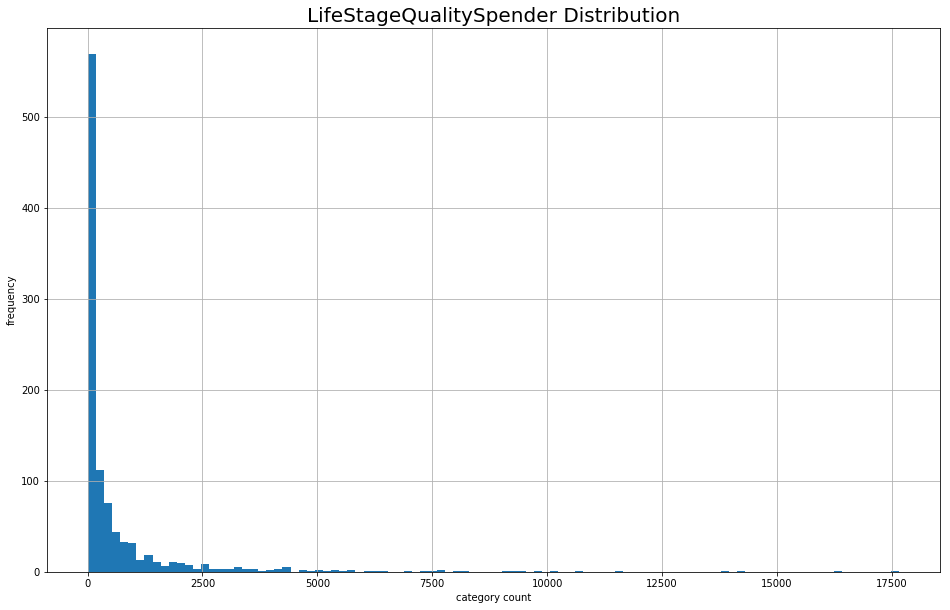

In [64]:
new_feature_hist(new_feature01, bins=100)

#### New Feature 01 Conclusion:
> Too much dimensionality and very skew to the right, which means highly sparse categories
---

#### 3.2 Investigating New Feature 02

In [65]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
investigate_two('CAMEO_INTL_2015', 'PLZ8_BAUMAX')

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
59,4.3,CAMEO_INTL_2015,INTL_2015,German CAMEO: Wealth / Life Stage Typology,True,mixed
79,8.6,PLZ8_BAUMAX,BAUMAX,Most common building type within the PLZ8 region,True,mixed


count
CAMEO_INTL_2015                                    PLZ8_BAUMAX                     
Comfortable Households - Elders In Retirement      mainly 1-2 family homes     5908
                                                   mainly 10+ family homes      793
                                                   mainly 3-5 family homes      823
                                                   mainly 6-10 family homes     631
                                                   mainly business buildings   1034
Comfortable Households - Families With School A... mainly 1-2 family homes     7186
                                                   mainly 10+ family homes      372
                                                   mainly 3-5 family homes      386
                                                   mainly 6-10 family homes     276
                                                   mainly business buildings    226
Comfortable Households - Older Families & Matur... mainly 1-2 family homes     7585
                                                   mainly 10+ family homes      538
                                                   mainly 3-5 family homes     2495
                                                   mainly 6-10 family homes     668
                                                   mainly business buildings   5040
Comfortable Households - Pre-Family Couples & S... mainly 1-2 family homes     9483
                                                   mainly 10+ family homes     1307
                                                   mainly 3-5 family homes     1206
                                                   mainly 6-10 family homes     767
                                                   mainly business buildings   2279
Comfortable Households - Young Couples With Chi... mainly 1-2 family homes     7889
                                                   mainly 10+ family homes      266
                                                   mainly 3-5 family homes      404
                                                   mainly 6-10 family homes     284
                                                   mainly business buildings    281
Less Affluent Households - Elders In Retirement    mainly 1-2 family homes    11240
                                                   mainly 10+ family homes     3407
                                                   mainly 3-5 family homes     2705
                                                   mainly 6-10 family homes    3158
                                                   mainly business buildings   3180
Less Affluent Households - Families With School... mainly 1-2 family homes    39341
                                                   mainly 10+ family homes      873
                                                   mainly 3-5 family homes     7002
                                                   mainly 6-10 family homes    1576
                                                   mainly business buildings   1670
Less Affluent Households - Older Families & Mat... mainly 1-2 family homes     8817
                                                   mainly 10+ family homes      458
                                                   mainly 3-5 family homes     2059
                                                   mainly 6-10 family homes     711
                                                   mainly business buildings   1081
Less Affluent Households - Pre-Family Couples &... mainly 1-2 family homes    38712
                                                   mainly 10+ family homes     6362
                                                   mainly 3-5 family homes     9087
                                                   mainly 6-10 family homes    5147
                                                   mainly business buildings  22602
Poorer Households - Elders In Retirement           mainly 1-2 family homes     6687
                                              

In [66]:
new_feature02 = create_two(azdias, 'CAMEO_INTL_2015', 'PLZ8_BAUMAX', 'CAMEO_INTL_2015_GROBE')

,CAMEO_INTL_2015,PLZ8_BAUMAX
0,51,1.0000
1,24,1.0000
2,43,2.0000
3,54,1.0000
4,22,1.0000


,CAMEO_INTL_2015,PLZ8_BAUMAX
0,Poorer Households - Pre-Family Couples & Singles,mainly 1-2 family homes
1,Prosperous Households - Older Families & Matur...,mainly 1-2 family homes
2,Less Affluent Households - Families With Schoo...,mainly 3-5 family homes
3,Poorer Households - Older Families & Mature Co...,mainly 1-2 family homes
4,Prosperous Households - Young Couples With Chi...,mainly 1-2 family homes


,CAMEO_INTL_2015_GROBE,count
104,Wealthy Households - Young Couples With Childr...,13
103,Wealthy Households - Young Couples With Childr...,26
101,Wealthy Households - Young Couples With Childr...,35
83,Prosperous Households - Young Couples With Chi...,49


Encoder will create 110 new features.



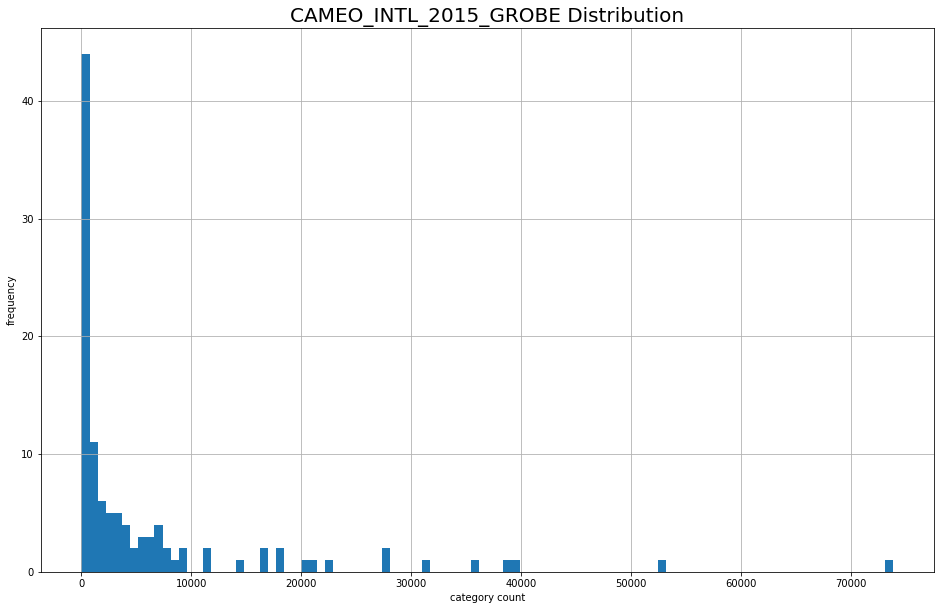

In [67]:
new_feature_hist(new_feature02, bins=100)

#### New Feature 02 Conclusion:
> There is less dicmensionality with this feature, and the distribution is more robust. Still there are some sparsity problems with it that need to be fixed where the frequency counts of some categories are less than 50.
---

#### 3.3 Investigating New Feature 03

In [68]:
investigate_two('PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_GROB')

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
16,1.12,LP_LEBENSPHASE_GROB,LEBENSPHASE_GROB,Life stage,True,mixed
22,1.18,PRAEGENDE_JUGENDJAHRE,JUGENDJAHRE,Dominating movement of person's youth (avantga...,True,mixed


count
PRAEGENDE_JUGENDJAHRE                          LP_LEBENSPHASE_GROB                                      
40s - reconstruction years (Avantgarde         high-income earner families                             6
                                               high-income earners of higher age from multiper...   1654
                                               high-income earners of younger age from multipe...      4
                                               low-income and average earners of higher age fr...    184
                                               single high-income earner couples                    1058
                                               single high-income earners                           2832
                                               single low-income and average earners of higher...    676
                                               single low-income and average earners of younge...      2
                                               single low-income and average-earner couples          198
                                               single parents                                         10
40s - war years (Mainstream                    average earners of younger age from multiperson...      1
                                               high-income earner families                            10
                                               high-income earners of higher age from multiper...   1313
                                               high-income earners of younger age from multipe...      5
                                               low-income and average earners of higher age fr...   1380
                                               single high-income earner couples                     701
                                               single high-income earners                           3232
                                               single low-income and average earner families           8
                                               single low-income and average earners of higher...   8870
                                               single low-income and average earners of younge...     17
                                               single low-income and average-earner couples         1675
                                               single parents                                         41
50s - economic miracle (Mainstream             average earners of younger age from multiperson...      8
                                               high-income earner families                            70
                                               high-income earners of higher age from multiper...   4381
                                               high-income earners of younger age from multipe...      1
                                               low-income and average earners of higher age fr...   4911
                                               single high-income earner couples                    4013
                                               single high-income earners                           7060
                                               single low-income and average earner families          59
                                               single low-income and average earners of higher...  21310
                                               single low-income and average earners of younge...     19
                                               single low-income and average-earner couples         6904
                                               single parents                                         91
50s - milk bar / Individualisation (Avantgarde average earners of younger age from multiperson...      1
                                               high-income earner families                            53
                                               high-income earners of higher age from multiper...   5433
    

In [69]:
new_feature03 = create_two(azdias, 'PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_GROB', 'MovementWealth')

,PRAEGENDE_JUGENDJAHRE,LP_LEBENSPHASE_GROB
0,14.0000,6.0000
1,15.0000,1.0000
2,8.0000,10.0000
3,3.0000,2.0000
4,10.0000,1.0000


,PRAEGENDE_JUGENDJAHRE,LP_LEBENSPHASE_GROB
0,90s - digital media kids (Mainstream,single parents
1,90s - ecological awareness (Avantgarde,single low-income and average earners of young...
2,70s - family orientation (Mainstream,low-income and average earners of higher age f...
3,50s - economic miracle (Mainstream,single low-income and average earners of highe...
4,80s - Generation Golf (Mainstream,single low-income and average earners of young...


,MovementWealth,count
34,50s - milk bar / Individualisation (Avantgarde...,1
94,70s - peace movement (Avantgarde - nan,1
25,50s - economic miracle (Mainstream - high-inco...,1
10,40s - war years (Mainstream - average earners ...,1
99,70s - peace movement (Avantgarde - single low-...,2
7,40s - reconstruction years (Avantgarde - singl...,2
65,60s - generation 68 / student protestors (Avan...,3
73,60s - opponents to the building of the Wall (A...,3
89,70s - peace movement (Avantgarde - average ear...,3
43,50s - milk bar / Individualisation (Avantgarde...,4


Encoder will create 183 new features.



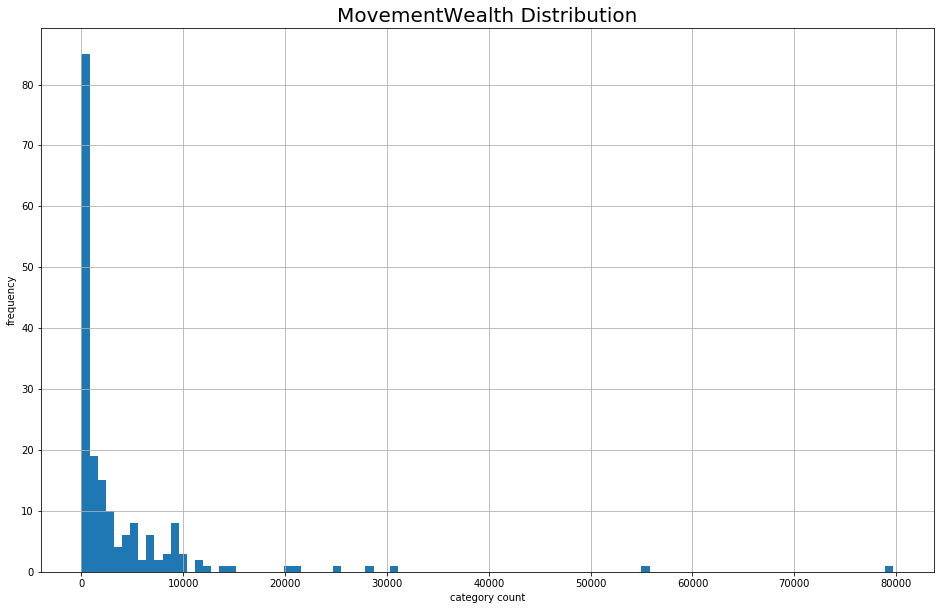

In [70]:
new_feature_hist(new_feature03, bins=100)

#### New Feature 03 Conclusion:
> There is more dimensionality with this one than the previous one. But not as much as the first one. The skewness is similar as the other one. But it has more sparsity where the categorie count is less than 50 than the previous one.
---

#### 3.4 Investigating New Feature 04

> FINAZ_AUSGEBEN was engineer to represent how susceptible is a instance to spend money.

In [71]:
investigate_two('PRAEGENDE_JUGENDJAHRE', 'FINAZ_AUSGEBEN')

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
22,1.18,PRAEGENDE_JUGENDJAHRE,JUGENDJAHRE,Dominating movement of person's youth (avantga...,True,mixed


count
PRAEGENDE_JUGENDJAHRE                              FINAZ_AUSGEBEN                
40s - reconstruction years (Avantgarde             low money-spender          127
                                                   very low money-spender    6497
40s - war years (Mainstream                        low money-spender         1581
                                                   very low money-spender   15672
50s - economic miracle (Mainstream                 low money-spender         4752
                                                   very low money-spender   44075
50s - milk bar / Individualisation (Avantgarde     low money-spender          435
                                                   very low money-spender   18865
60s - economic miracle (Mainstream                 low money-spender         8730
                                                   very low money-spender   68863
60s - generation 68 / student protestors (Avant... low money-spender          719
                                                   very low money-spender   23351
60s - opponents to the building of the Wall (Av... low money-spender          128
                                                   very low money-spender    3607
70s - family orientation (Mainstream               average money-spender    52076
                                                   high money-spender        2799
                                                   low money-spender        48036
                                                   very high money-spender     20
                                                   very low money-spender   23954
70s - peace movement (Avantgarde                   average money-spender     3943
                                                   high money-spender         149
                                                   low money-spender        18241
                                                   very high money-spender      1
                                                   very low money-spender    8667
80s - FDJ / communist party youth organisation ... average money-spender     8688
                                                   high money-spender        4967
                                                   low money-spender         5561
                                                   very high money-spender   3081
                                                   very low money-spender      65
80s - Generation Golf (Mainstream                  average money-spender    30264
                                                   high money-spender       14083
                                                   low money-spender        21897
                                                   very high money-spender  10049
                                                   very low money-spender     110
80s - Swords into ploughshares (Avantgarde         average money-spender     1523
                                                   high money-spender         823
                                                   low money-spender         2353
                                                   very high money-spender    248
                                                   very low money-spender       9
80s - ecological awareness (Avantgarde             average money-spender     8541
                                                   high money-spender        3644
                                                   low money-spender        18057
                                                   very high money-spender    958
                                                   very low money-spender      44
90s - digital media kids (Mainstream               average money-spender    11470
                                                   high money-spender       59158
                                                   low money-spender          267
                                                   very hi

In [72]:
new_feature04 = create_two(azdias, 'PRAEGENDE_JUGENDJAHRE', 'FINAZ_AUSGEBEN', 'PRAEGENDE_JUGENDJAHRE_AUSGEBEN')

,PRAEGENDE_JUGENDJAHRE,FINANZ_SPARER
0,14.0000,5.0000
1,15.0000,4.0000
2,8.0000,3.0000
3,3.0000,1.0000
4,10.0000,5.0000


*FINANZ_SPARER was converted to FINAZ_AUSGEBEN inversively


,PRAEGENDE_JUGENDJAHRE,FINAZ_AUSGEBEN
0,90s - digital media kids (Mainstream,very high money-spender
1,90s - ecological awareness (Avantgarde,high money-spender
2,70s - family orientation (Mainstream,average money-spender
3,50s - economic miracle (Mainstream,very low money-spender
4,80s - Generation Golf (Mainstream,very high money-spender


,PRAEGENDE_JUGENDJAHRE_AUSGEBEN,count
22,70s - peace movement (Avantgarde - very high m...,1
53,90s - ecological awareness (Avantgarde - very ...,6
38,80s - Swords into ploughshares (Avantgarde - v...,9
48,90s - digital media kids (Mainstream - very lo...,16
17,70s - family orientation (Mainstream - very hi...,20
43,80s - ecological awareness (Avantgarde - very ...,44


Encoder will create 56 new features.



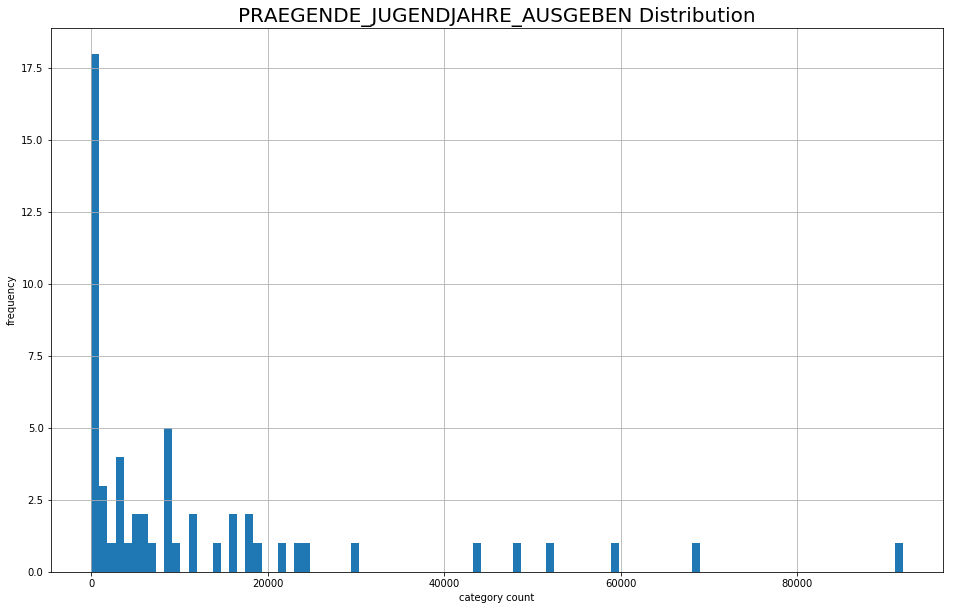

In [73]:
new_feature_hist(new_feature04, bins=100)

### New Feature 04 Conclusion
> This is the one that creates less dimensionality. At the same time it is the most robust of all new features where the category counts are less than 50. It seems that I can categorize the ones below to 50 under one category by combining all Avantgrade and Mainstream and create buckets for this one. I will add this one to the analysis as is. If needed, I will reduce the sparsity of the data.
---

#### Discussion 1.2.2: Engineer Mixed-Type Features

>While creating 4 new features, I found interesting relationships in the data. The first relationship combined life stage, the quality of a household, and the likelyhood of spending. The secodn relationship combined the wealth/life stage with the most common housholde building type in the region. The third relationship combined the dominating movement with the life stage. And the last relationship combined the dominating movement with the likelyhood of spending. 

>To check for the quality of the new features, I check the sparsity of the categories. Those categories with less than 50 counts are problematic and give no meaning. Thus, the more of this are created without the posibility of merging some categories are deemed to be problematic. Therefore, new features following this pattern will be discarted. The last feature (new_feature04) will be used in the analysis due to its low content of sparcity and dimensionality.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### 1. Create New Feature, Encode, and Include in Data
---

In [74]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [75]:
print(f'Validating Azdias Shape: {azdias.shape}')

Validating Azdias Shape: (697109, 197)


In [76]:
# encode new feature
new_feature04_enc = pd.DataFrame(sweet_encode(new_feature04, encoder)[0])

Endoding: PRAEGENDE_JUGENDJAHRE_AUSGEBEN


In [77]:
print(f'Original Azdias Shape: {azdias_original_shape}'+
      f'\nEncoded Frame Shape: {azdias_encoded.shape}'+
      f'\nGood set Shape: {azdias_good.shape}'+
      f'\nTo-encode Categorial Shape: {azdias_toencode.shape}'+
      f'\nUencoded Shape: {azdias_unencoded.shape}'+
      f'\nUencoded + Encoded Shape: {azdias.shape}'+
      f'\nNew Feature Shape: {new_feature04_enc.shape}'+
      f'\nUencoded + Encoded + NewFeature Shapes: {azdias.shape + new_feature04_enc.shape}')

Original Azdias Shape: (891221, 85)
Encoded Frame Shape: (697109, 132)
Good set Shape: (697109, 79)
To-encode Categorial Shape: (697109, 14)
Uencoded Shape: (697109, 65)
Uencoded + Encoded Shape: (697109, 197)
New Feature Shape: (697109, 56)
Uencoded + Encoded + NewFeature Shapes: (697109, 197, 697109, 56)


In [78]:
# finalizing dataset
azdias = pd.concat([azdias, new_feature04_enc], axis=1)

In [79]:
print(f'Azdias Complete Shape: {azdias.shape}')

Azdias Complete Shape: (697109, 253)


In [80]:
# removing redundant features
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [81]:
print(f'Azdias Final Shape: {azdias.shape}')

Azdias Final Shape: (697109, 252)


In [82]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print(f'Number of NaNs that need removal: {azdias.isna().sum().sum():,}')

Number of NaNs that need removal: 139,238


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [83]:
def clean_data(df, col_treshold=.05):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_parsed, nan_parsed = nan_parse(df, feat_info)
    
    # remove selected columns and rows, ...
    df_reduced_col = remove_outliers(df_parsed) # columns
    df_split_set = separate_row_sets(df_reduced_col, col_treshold) # rows
    df_reduced_row = df_split_set[0].copy()
    
    reduced_column_list = list(df_reduced_row.columns)
    
    # select, re-encode, and engineer column values.
    df_unencoded, df_toencode, dropped_columns = get_categorical(df_reduced_row, 
                                                    reduced_column_list, 
                                                    show=True)    
    
    df_encoded, encoder = set_encoding(df_toencode)
    
    
    print('\nStatus: \nUencoded columns: {}\trows: {:,}'\
          .format(df_unencoded.shape[1], df_toencode.shape[0]) +\
          '\nToEncode columns: {}\trows: {:,}'\
          .format(df_toencode.shape[1], df_toencode.shape[0]) +\
          '\nEncoded columns: {}\trows: {:,}'\
          .format(df_encoded.shape[1], df_encoded.shape[0]))   
      
    # create and add new feature  
    new_feature = create_two(df_reduced_row, 
                             feature01='PRAEGENDE_JUGENDJAHRE', 
                             feature02='FINAZ_AUSGEBEN', 
                             feature_name='PRAEGENDE_JUGENDJAHRE_AUSGEBEN')
    new_feature_enc = pd.DataFrame(sweet_encode(new_feature, encoder)[0])   
    
    # user stats
    print('Status:'+\
          '\n\tNew feature unique count: %s' % new_feature.nunique().item()+\
          '\n\tEncoding column count: %s' % new_feature_enc.shape[1]+\
          '\n\tEncoded rows: {:,}'.format(new_feature_enc.shape[0]))
    
    print('\nThe final column count: {}'\
          .format(df_unencoded.shape[1] + df_encoded.shape[1] + new_feature_enc.shape[1]))
    
    # concat datasets
    df_completed = pd.concat([df_unencoded, df_encoded, new_feature_enc], axis=1)
    df_completed.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True) 
    
    clean_msg = '*'*5 + 'Clean Data Achieved' + '*'*5
    display_html(clean_msg, center=True)
    
    # Return the cleaned dataframe.
    return df_completed.astype(float), df_split_set

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

### 1. Assess NaN Removals by Percentage Impact
---

In [84]:
pd.options.display.float_format = '{:2.2%}'.format
frame_nulls_left \
    = pd.DataFrame(azdias.isna().sum(), columns=['Null_Counts'])\
        .query("Null_Counts > 0")\
        .sort_values('Null_Counts')
frame_nulls_left['Null_Pct'] = frame_nulls_left.Null_Counts / azdias.shape[0]
display(frame_nulls_left\
            .merge(feat_info[['attribute', 'type']]\
                   .set_index('attribute'),
                          left_index=True, right_index=True, how='left')\
            .sort_values('Null_Pct', ascending=False))

,Null_Counts,Null_Pct,type
REGIOTYP,38385,5.51%,ordinal
KKK,38385,5.51%,ordinal
W_KEIT_KIND_HH,18199,2.61%,ordinal
HEALTH_TYP,12251,1.76%,ordinal
VERS_TYP,12251,1.76%,categorical
RELAT_AB,3504,0.50%,ordinal
ARBEIT,3504,0.50%,ordinal
ORTSGR_KLS9,3430,0.49%,ordinal
CAMEO_INTL_2015,2841,0.41%,mixed
ANZ_HAUSHALTE_AKTIV,2579,0.37%,numeric


In [85]:
pd.options.display.float_format = '{:2.4f}'.format
frame_nulls_left.sum()

Null_Counts   139238.0000
Null_Pct           0.1997
dtype: float64

>**Remove all conclussion**: Removing all rows with nulls will result in at most 20% of dataset removal, which is quite significant. It dependes on which null values are shared null values row by row.

In [86]:
frame_keep_nulls\
    = frame_nulls_left[['Null_Pct']]\
        .sort_values('Null_Pct', ascending=False)\
        .cumsum()\
        .pct_change()\
        .query("Null_Pct > 0.01 or Null_Pct != Null_Pct")\
                .merge(feat_info[['attribute', 'type']]\
                       .set_index('attribute'),
                              left_index=True, right_index=True, how='left')
frame_keep_nulls

,Null_Pct,type
REGIOTYP,nan,ordinal
KKK,1.0000,ordinal
W_KEIT_KIND_HH,0.2371,ordinal
HEALTH_TYP,0.1290,ordinal
VERS_TYP,0.1143,categorical
RELAT_AB,0.0293,ordinal
ARBEIT,0.0285,ordinal
ORTSGR_KLS9,0.0271,ordinal
CAMEO_INTL_2015,0.0219,mixed
ANZ_HAUSHALTE_AKTIV,0.0194,numeric


>Note: The percentage change is significat for the above features.

In [87]:
remove_nan = frame_nulls_left[['Null_Pct']]\
    .sort_values('Null_Pct', ascending=False)\
    .cumsum()\
    .pct_change()\
    .query("Null_Pct < 0.01").index
print(f'Removing Row with NaNs for the following features: {list(remove_nan)}')
frame_nulls_left.query(f"index == {list(remove_nan)}").sum()

Removing Row with NaNs for the following features: ['KBA13_ANZAHL_PKW', 'ANZ_HH_TITEL', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'KONSUMNAEHE', 'GEBAEUDETYP_RASTER', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']


Null_Counts   2492.0000
Null_Pct         0.0036
dtype: float64

>**Remove low percentage impact conclussion**: Removing rows with NaNs out of these ones makes sense since the removal is insignificant.

In [88]:
frame_nulls_left.query(f"index != {list(remove_nan)}").sum()

Null_Counts   136746.0000
Null_Pct           0.1962
dtype: float64

>**Keep high percentage impact conclussion**: Assess imputation of features with high percentage impact.

### 2. Assessing the Ideal Imputing Method
---

In [89]:
head = 5 # change number to see more data value descriptions
display_html('Value Keys for Features with More than 5% NaNs')
data_dict_view\
    .query(f"ColumnName == {list(frame_keep_nulls.index)}")\
    .merge(feat_info[['attribute', 'type']]\
           .rename(columns={'attribute':'ColumnName'}), on='ColumnName', how='left')\
    .head(head)

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta,type
0,1.10,2,sanitary affine,HEALTH_TYP,TYP,Health typology,NaN,ordinal
1,1.10,1,critical reserved,HEALTH_TYP,TYP,Health typology,NaN,ordinal
2,1.10,3,jaunty hedonists,HEALTH_TYP,TYP,Health typology,NaN,ordinal
3,1.10,-1,unknown,HEALTH_TYP,TYP,Health typology,NaN,ordinal
4,1.10,0,classification not possible,HEALTH_TYP,TYP,Health typology,NaN,ordinal


#### 2.1 Numerical Assessment
---
---

In [90]:
data_dict_coldesc.query(f"type == 'numeric' and Kept == True and ColumnName == {list(frame_keep_nulls.index)}")

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
50,3.1,ANZ_HAUSHALTE_AKTIV,HAUSHALTE_AKTIV,Number of households in the building,True,numeric


In [91]:
pd.options.display.float_format = '{:2.2f}'.format
azdias[['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'ANZ_HH_TITEL']].describe()

,ANZ_HAUSHALTE_AKTIV,KBA13_ANZAHL_PKW,ANZ_HH_TITEL
count,694530.00,696485.00,696546.00
mean,8.41,616.41,0.04
std,15.42,337.36,0.31
min,1.00,0.00,0.00
25%,2.00,382.00,0.00
50%,4.00,546.00,0.00
75%,10.00,773.00,0.00
max,536.00,2300.00,20.00


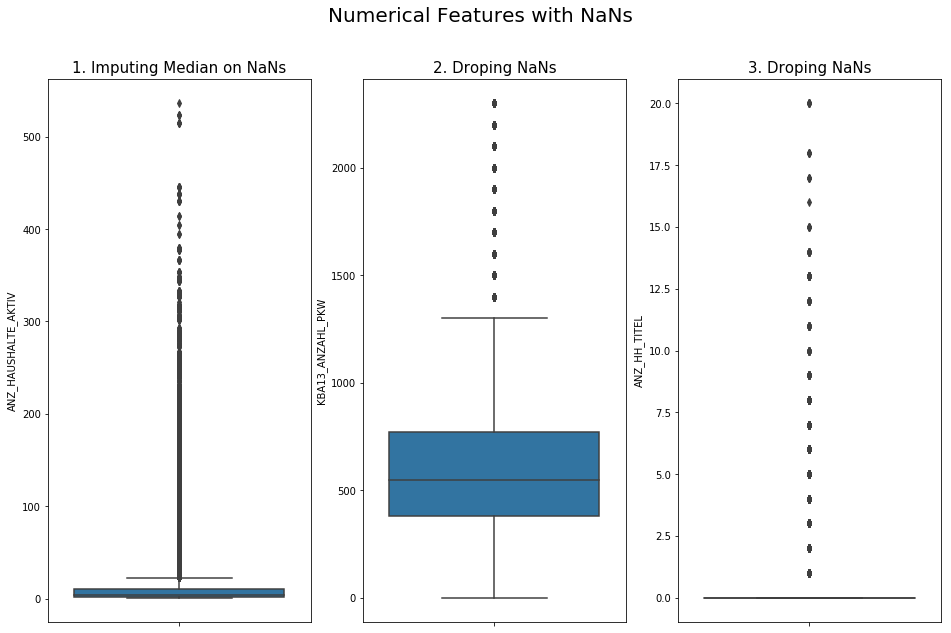

In [92]:
plt.figure(figsize=(16, 10))
plt.suptitle('Numerical Features with NaNs', size=20)
plt.subplot(131)
plt.title('1. Imputing Median on NaNs', size=15)
sns.boxplot(y='ANZ_HAUSHALTE_AKTIV', data=azdias)
plt.subplot(132)
plt.title('2. Droping NaNs', size=15)
sns.boxplot(y='KBA13_ANZAHL_PKW', data=azdias)
plt.subplot(133)
plt.title('3. Droping NaNs', size=15)
sns.boxplot(y='ANZ_HH_TITEL', data=azdias)
plt.show()

> **Numerical Imputing Conclussion**: 
> - I am imputing the median for numerical feature number 1. This feaature has a significant NaN percentage impact, thus the rows will be kept.
> - On the contrary, feature number 2 and 3 have very low NaN percentage impact. Therefore, imputation will be ignored and rows with NaNs will be removed.
---

#### 2.2 Ordinal, Mixed, and Categorical Assessment
---
---

In [93]:
def show_cat_plots():
    fig1, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

    ax11, ax12, ax21, ax22 = ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]

    plt.suptitle('Count Plots of Top 4 Non-Numerical Features', size=20)
    
    if azdias.isna().sum().sum() > 0: i = 0
    else: i = 1

    # draw plots
    sns.countplot(x=azdias.KKK.fillna(0), ax=ax11)
    ax11.vlines(x=azdias.KKK.median()-i, ymin=0, ymax=azdias.groupby('KKK').size().max())
    sns.countplot(x=azdias.REGIOTYP.fillna(0), ax=ax12)
    ax12.vlines(x=azdias.REGIOTYP.median()-i, ymin=0, ymax=azdias.groupby('REGIOTYP').size().max())
    sns.countplot(x=azdias.W_KEIT_KIND_HH.fillna(0), ax=ax21)
    ax21.vlines(x=azdias.W_KEIT_KIND_HH.median()-i, ymin=0, ymax=azdias.groupby('W_KEIT_KIND_HH').size().max())
    sns.countplot(x=azdias.HEALTH_TYP.fillna(0), ax=ax22)
    ax22.vlines(x=azdias.HEALTH_TYP.median()-i, ymin=0, ymax=azdias.groupby('HEALTH_TYP').size().max())

    plt.show()

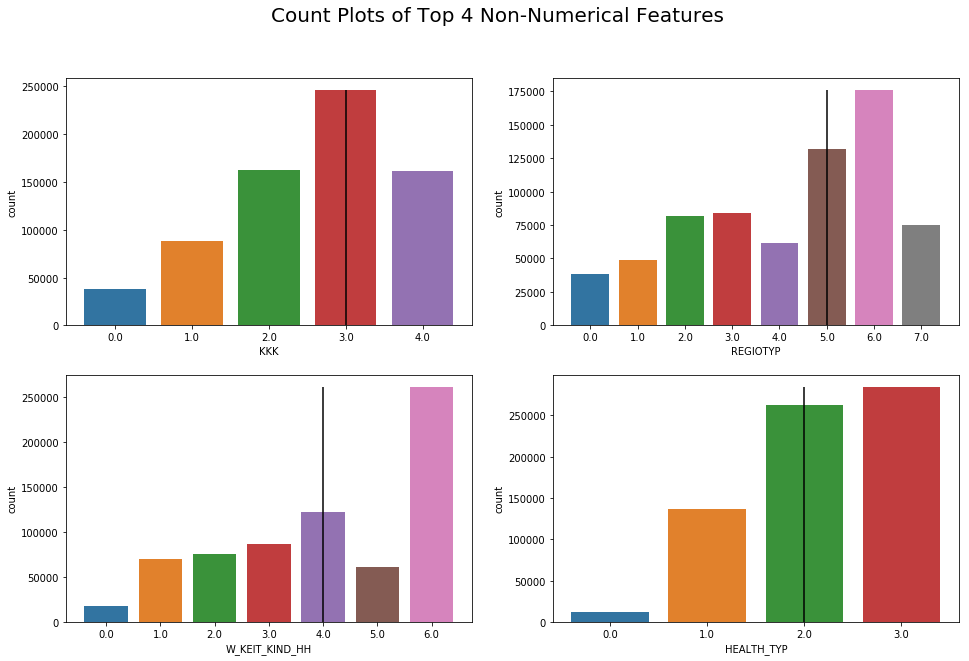

In [94]:
show_cat_plots()

> **Non-numercal feature conclussion**: At first, I contemplated the idea of using the mode to fill the null values. But after seeing the distribution of counts, I notice that the method will just create more peak specially in REGIOTYP. For that reason, I decided to use the median to redistribute. There is always a chance that a method might be the wrong one since we are predicting on the population. But the mean method feels right in this case. The rest of the features have less NaN percentage impact. Therefore, they are not going to be significant in the imputation method selection.

### 3. Imputate or/and Remove NaN values as Assessed
---

#### 3.1 Remove NaNs
---
---

In [95]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
subset = list(remove_nan)

In [96]:
current_rows = azdias.shape[0]
azdias.dropna(axis=0, how='any', subset=subset, inplace=True)
reduced_rows =  azdias.shape[0]
drop_rows = current_rows-reduced_rows
print(f'Azdias was reduced by {drop_rows:,}, which is a {drop_rows/current_rows:2.2%} reduction.')

Azdias was reduced by 1,645, which is a 0.24% reduction.


#### 3.2 Impute Rounded Medians
---
---

In [97]:
from sklearn.impute import SimpleImputer

In [98]:
subset = list(frame_nulls_left.query(f"index != {list(remove_nan)}").index)

In [99]:
azdias.CAMEO_INTL_2015 = azdias.CAMEO_INTL_2015.astype(float)

In [100]:
azdias.loc[:, subset].dtypes

ALTERSKATEGORIE_GROB    float64
ANZ_HAUSHALTE_AKTIV     float64
CAMEO_INTL_2015         float64
ORTSGR_KLS9             float64
ARBEIT                  float64
RELAT_AB                float64
VERS_TYP                float64
HEALTH_TYP              float64
W_KEIT_KIND_HH          float64
KKK                     float64
REGIOTYP                float64
dtype: object

> Note: Since there is not demcial places in the numeric feature ANZ_HAUSHALTE_AKTIV, we can use a round median to impute.

In [101]:
azdias.loc[:, subset].shape

(695464, 11)

In [102]:
pd.DataFrame(azdias.isna().sum(), columns=['NaNs']).query("NaNs > 0")

,NaNs
ALTERSKATEGORIE_GROB,1417
HEALTH_TYP,12251
VERS_TYP,12251
W_KEIT_KIND_HH,17618
ANZ_HAUSHALTE_AKTIV,2000
CAMEO_INTL_2015,2779
KKK,38349
REGIOTYP,38349
ARBEIT,3504
ORTSGR_KLS9,3430


In [103]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
azdias = pd.DataFrame(imp_median.fit_transform(azdias), columns=azdias.columns)

In [104]:
pd.options.display.max_rows = 300
pd.DataFrame([imp_median.statistics_, azdias.columns]).T\
    .rename(columns={0:'Imputated Median', 1:'Feature'})\
    .query(f"Feature == {subset}")

,Imputated Median,Feature
0,3.00,ALTERSKATEGORIE_GROB
9,2.00,HEALTH_TYP
28,2.00,VERS_TYP
32,4.00,W_KEIT_KIND_HH
34,4.00,ANZ_HAUSHALTE_AKTIV
39,41.00,CAMEO_INTL_2015
49,3.00,KKK
52,5.00,REGIOTYP
61,3.00,ARBEIT
62,5.00,ORTSGR_KLS9


> Note: There was no need to round the medians since each imputation matches perfectly with the data dictionary.

In [105]:
print(f'Validating Azdias Shape Again: {azdias.shape}')

Validating Azdias Shape Again: (695464, 252)


In [106]:
print(f'Validating NaNs: {azdias.isna().sum().sum()}'+
      f"\n{'Data is ready to scale, pca, kemans' if azdias.isna().sum().sum() == 0 else ''}")

Validating NaNs: 0
Data is ready to scale, pca, kemans


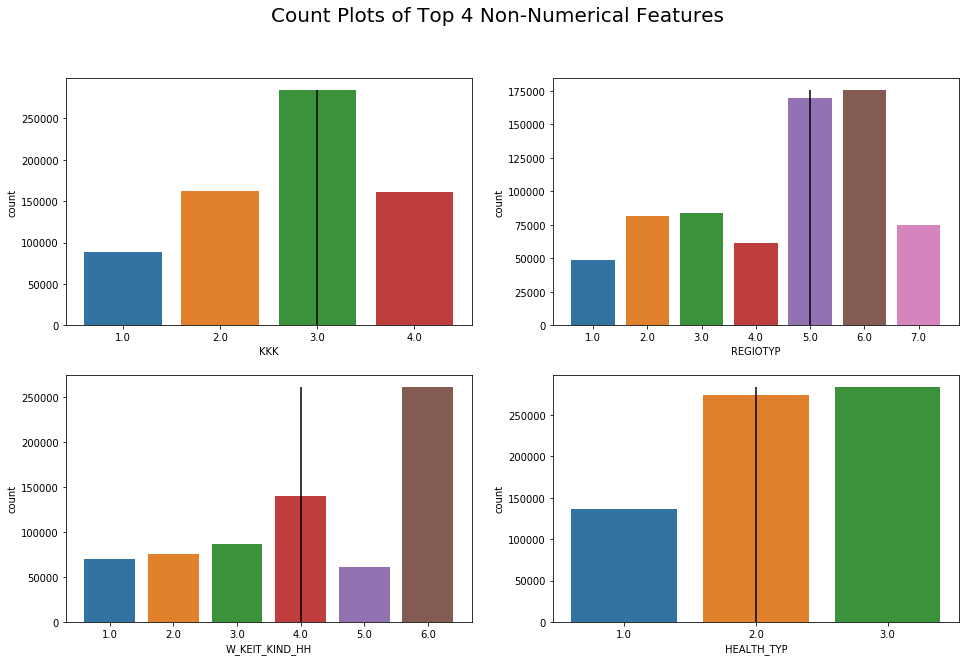

In [107]:
show_cat_plots()

### 4. Scale the Data
---

In [108]:
def do_standarscaler(dataframe):
    start = TickTock()
    scaler = StandardScaler()
    X = scaler.fit_transform(dataframe)
    print(f'Time to process: {start.stop_clock()}')
    return X

In [109]:
# Apply feature scaling to the general population demographics data.
X = do_standarscaler(azdias)

Time to process: 0:00:07.391448


### Discussion 2.1: Apply Feature Scaling

> - At first I check the impact of removing all the NaNs. I came to realize that removing all rows with NaNs would take at most ~20% of the data. Therefore, instead I calculated the percentage change of the cumulative percentage to provide a percentage impact. Anything with less than .01% impact was determined to be removed. 
>- From the features left from which I was going to keep rows and do imputations, there was a numerical feature. 
ANZ_HAUSHALTE_AKTIV was heavily skewed to the right. Therefore, the mean imputation strategy did not seem the right approach. I decided a median imputation for the numerical feature. 
>- The rest of the features, the categorical, mixed, and ordinal, had some high peaks, especially in REGIOTYP. Thus, imputing on mode would have increased the peaks. That did not seem right. So I decided to imputate the median as well for these features.
The reduction of data only reduced 0.24% of the rows. And the median imputations needed no rounding to match the data dictionary.




### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [110]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
        #ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Cumulative Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component', size=20)

In [111]:
def do_pca(n_components, X_scaled):
    start = TickTock()
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X_scaled)
    print(f'Time to process: {start.stop_clock()}')
    return pca, X_pca

In [112]:
# Apply PCA to the data.
def find_n_component(scaled_data, full_dataset, steps=1):
    X = scaled_data
    for comp in range(3, X.shape[1], steps):
        pca, X_pca = do_pca(comp, X)
        comp_check = pca_results(full_dataset, pca)
        print('{} components will explain {:2.2%} of the variance.'\
              .format(comp, comp_check['Explained_Variance'].sum()))
        if comp_check['Explained_Variance'].sum() > .85:
            return comp
            break   

In [113]:
#n_component = find_n_component(X)
n_components = 138

In [114]:
# Re-apply PCA to the data while selecting for number of components to retain.
azdias_pca, X_pca = do_pca(n_components, X)

Time to process: 0:00:42.662521


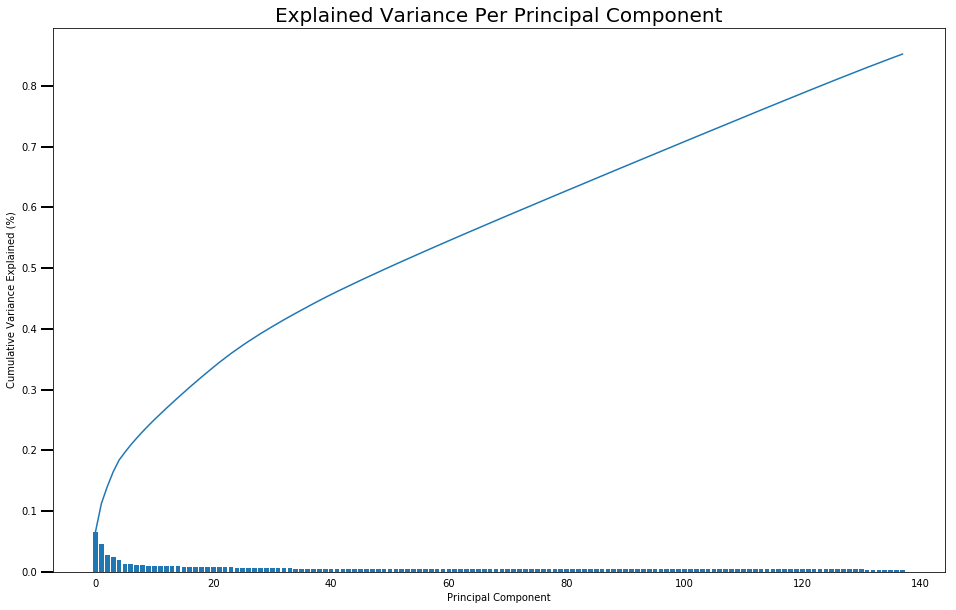

In [115]:
# Investigate the variance accounted for by each principal component.
scree_plot(azdias_pca)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

> After performing dimensionality reduction, I will keep 138 components for the next step of the analysis as the 138 components can explain > 85% of the variance. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [116]:
def frame_principal_components(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension_{}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained_Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [117]:
def get_principal_component(dataframe_components, component_namenum, show=False):
    # extract specific principal component
    principal_component01 = dataframe_components.loc[[component_namenum], :].iloc[:, 1:]

    # very rare and important weights 
    q3 = principal_component01.T.quantile(.75).item()
    q1 = principal_component01.T.quantile(.25).item()
    dim01_top = q3 + (q3-q1)*1.5 
    dim01_low = q1 - (q3-q1)*1.5 

    # plot the weights
       
    principal_results = principal_component01.T.query("{comp} > {top} or {comp} < {bottom}"\
                                  .format(comp=component_namenum, top=dim01_top, bottom=dim01_low))\
                           .sort_values(component_namenum, ascending=False)    
    principal_results['Rank'] = principal_results[[component_namenum]].rank().astype(int)
    
    if show:
        display_html('Descriptive Stats')
        display(principal_component01.T.describe())
        fig, ax = plt.subplots(figsize = (16, 15))
        principal_results[[component_namenum]].T.plot(ax=ax, kind='bar')
        plt.title('Principal Component Valuable Weights', size=20)
        plt.xticks(rotation=.45, size=15)
        plt.yticks(size=15)
        plt.show()
    
    return principal_results

### 1. Analyze the First 3 Principal Components
---

In [118]:
azdias_components = frame_principal_components(azdias, azdias_pca)

In [119]:
azdias.shape

(695464, 252)

In [120]:
azdias_components.shape

(138, 253)

> Note: 253 because it includes the Explained Variance.

#### 1.1 First Princial Component
---
---

,Dimension_1
count,252.00
mean,-0.00
std,0.06
min,-0.20
25%,-0.03
50%,-0.00
75%,0.02
max,0.19


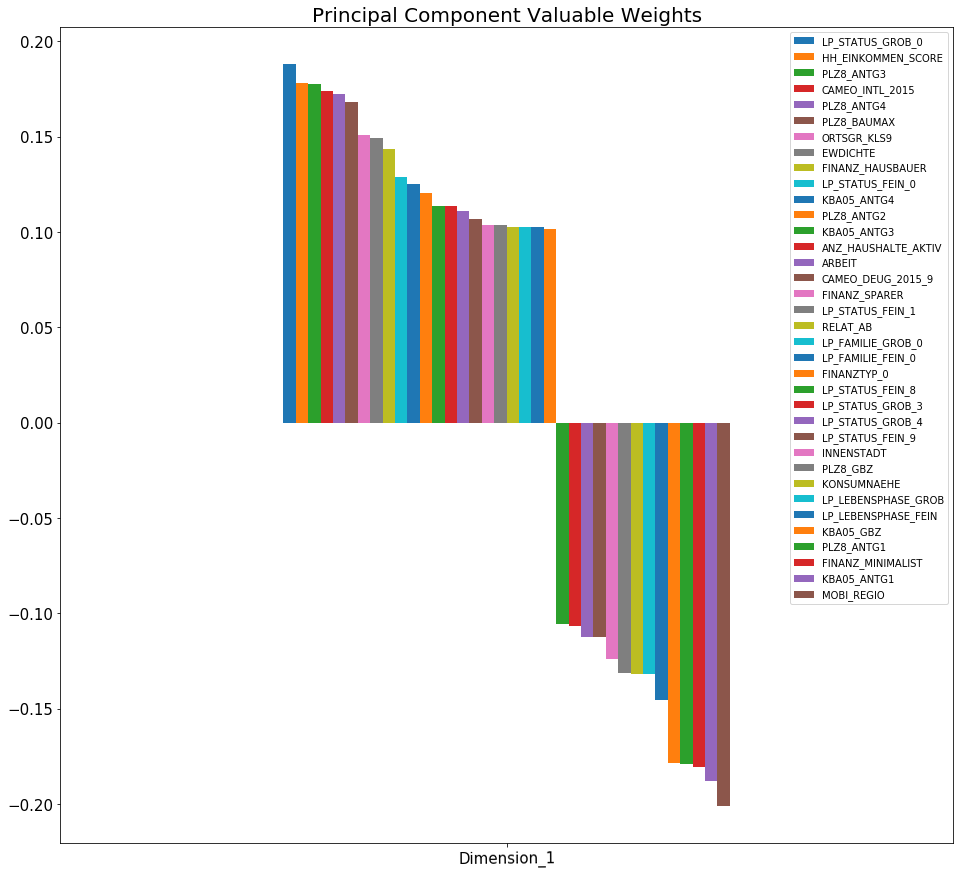

,Dimension_1,Rank
LP_STATUS_GROB_0,0.19,36
HH_EINKOMMEN_SCORE,0.18,35
PLZ8_ANTG3,0.18,34
CAMEO_INTL_2015,0.17,33
PLZ8_ANTG4,0.17,32
PLZ8_BAUMAX,0.17,31
ORTSGR_KLS9,0.15,30
EWDICHTE,0.15,29
FINANZ_HAUSBAUER,0.14,28
LP_STATUS_FEIN_0,0.13,27


In [121]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
get_principal_component(azdias_components, 'Dimension_1', show=True)

> **First principal component conclussion**: 
- We have LP_STATUS_GROB encoding 0 in the upper side, which represents social status of low-income earners; and MOBI_REGIO in the lower side, which represents movement patters . 
- It is followed by the HH_EINKOMMEN_SCORE in the upper side, wich represent estimated household net income; and KBA05_ANTG1 in the lower side, which represents the number of houses in the microcell.

In [122]:
x = encoder['LP_STATUS_GROB']
x.classes_

array([1, 2, 3, 4, 5], dtype=int8)

In [123]:
data_dict_view\
    .query("ColumnName == ('LP_STATUS_GROB', 'MOBI_REGIO', 'HH_EINKOMMEN_SCORE', 'KBA05_ANTG1')")\
    .sort_values(['key', 'value_key'])

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
79,1.16,1,low-income earners (maps to 1-2 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
80,1.16,2,average earners (maps to 3-5 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
83,1.16,3,independents (maps to 6-7 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
81,1.16,4,houseowners (maps to 8-9 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
82,1.16,5,top earners (maps to 10 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
366,2.4,0,unknown,HH_EINKOMMEN_SCORE,EINKOMMEN_SCORE,Estimated household net income,NaN
365,2.4,1,highest income,HH_EINKOMMEN_SCORE,EINKOMMEN_SCORE,Estimated household net income,NaN
368,2.4,2,very high income,HH_EINKOMMEN_SCORE,EINKOMMEN_SCORE,Estimated household net income,NaN
363,2.4,3,high income,HH_EINKOMMEN_SCORE,EINKOMMEN_SCORE,Estimated household net income,NaN
364,2.4,4,average income,HH_EINKOMMEN_SCORE,EINKOMMEN_SCORE,Estimated household net income,NaN


#### 1.2 Second Princial Component
---
---

,Dimension_2
count,252.00
mean,-0.00
std,0.06
min,-0.23
25%,-0.03
50%,-0.00
75%,0.02
max,0.23


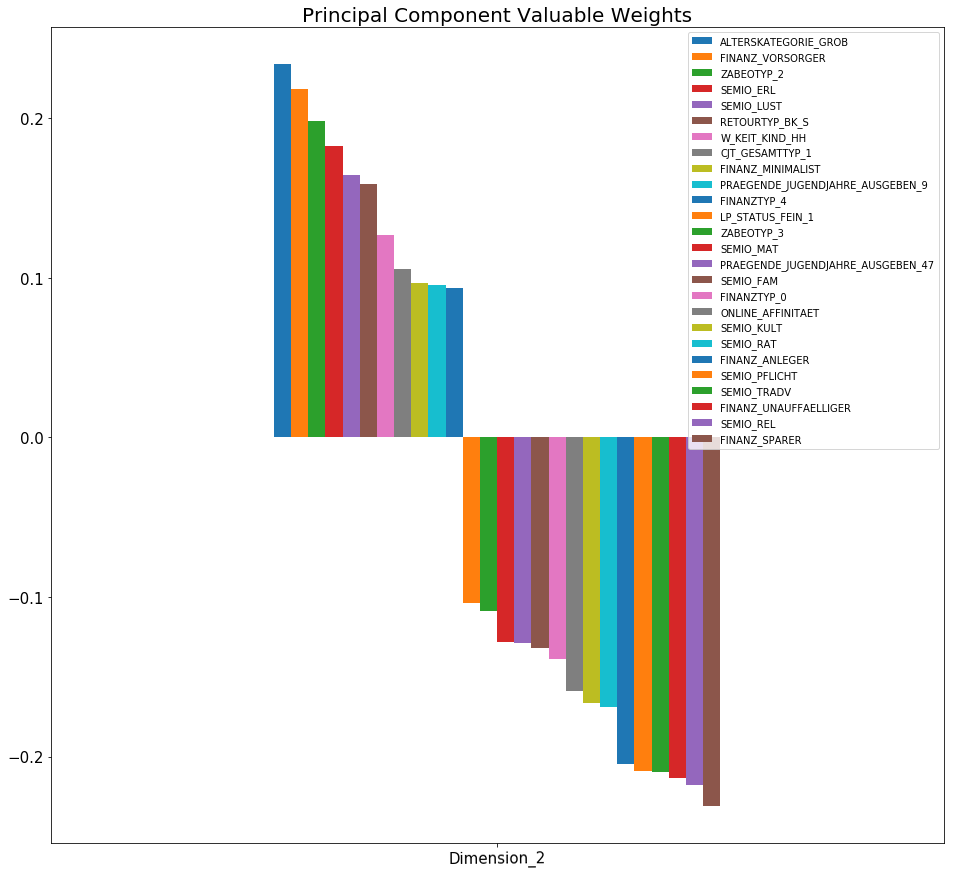

,Dimension_2,Rank
ALTERSKATEGORIE_GROB,0.23,26
FINANZ_VORSORGER,0.22,25
ZABEOTYP_2,0.20,24
SEMIO_ERL,0.18,23
SEMIO_LUST,0.16,22
RETOURTYP_BK_S,0.16,21
W_KEIT_KIND_HH,0.13,20
CJT_GESAMTTYP_1,0.11,19
FINANZ_MINIMALIST,0.10,18
PRAEGENDE_JUGENDJAHRE_AUSGEBEN_9,0.10,17


In [124]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_principal_component(azdias_components, 'Dimension_2', show=True)

> **First principal component conclussion**:
- We have ALTERSKATEGORIE_GROB in the upper side, which represents the estimated age; and FINANZ_SPARER in the lower side, which represent the religious personality typology. 
- It is followed by the FINANZ_VORSORGER in the upper side, which represents the be prepared financial typology; and SEMIO_REL in the lower side, which represent the money-saver financial typology.

In [125]:
data_dict_view\
    .query("ColumnName == ('ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'SEMIO_REL', 'FINANZ_SPARER')")\
    .sort_values(['key', 'ColumnName', 'value_key'])

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
113,1.2,0,unknown (cannot be determined),ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
114,1.2,1,< 30 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
115,1.2,2,30 - 45 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
116,1.2,3,46 - 60 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
117,1.2,4,> 60 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
118,1.2,9,uniformly distributed,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
112,1.2,-1,unknown (missing),ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
219,1.20,1,highest affinity,SEMIO_REL,REL,Personality typology,religious
205,1.20,2,very high affinity,SEMIO_REL,REL,Personality typology,religious
191,1.20,3,high affinity,SEMIO_REL,REL,Personality typology,religious


#### 1.3 Third Princial Component
---
---

,Dimension_3
count,252.00
mean,0.00
std,0.06
min,-0.33
25%,-0.01
50%,0.00
75%,0.02
max,0.31


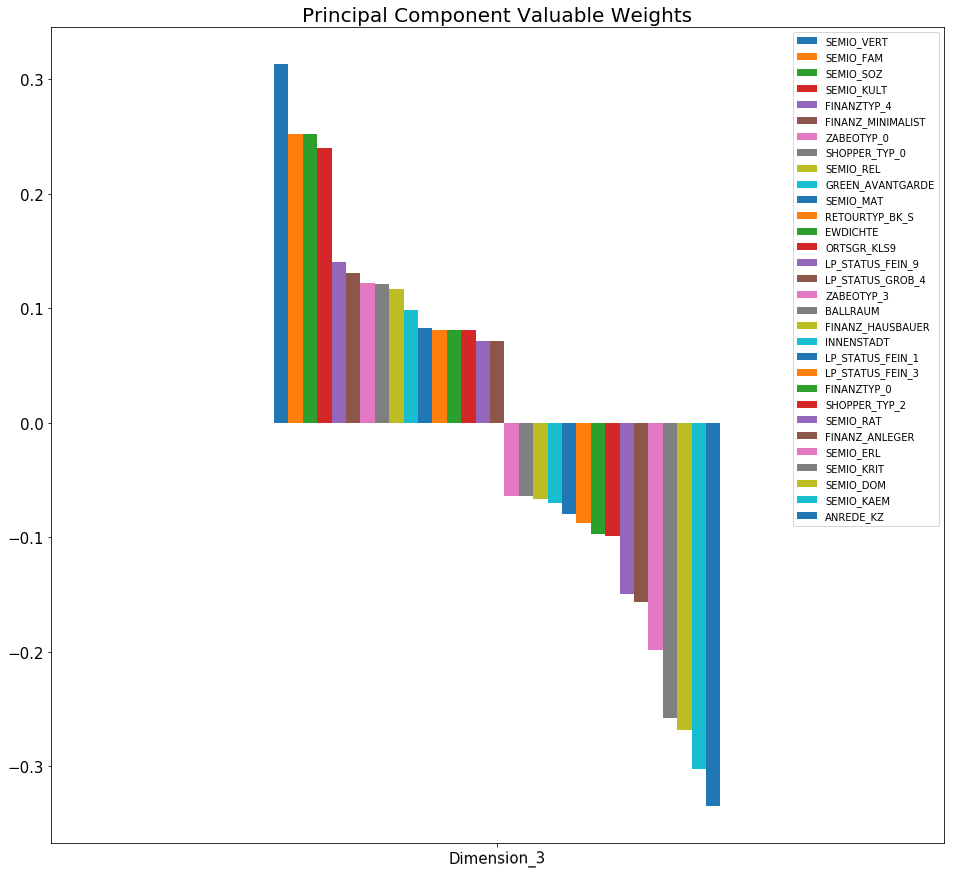

,Dimension_3,Rank
SEMIO_VERT,0.31,31
SEMIO_FAM,0.25,30
SEMIO_SOZ,0.25,29
SEMIO_KULT,0.24,28
FINANZTYP_4,0.14,27
FINANZ_MINIMALIST,0.13,26
ZABEOTYP_0,0.12,25
SHOPPER_TYP_0,0.12,24
SEMIO_REL,0.12,23
GREEN_AVANTGARDE,0.10,22


In [126]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_principal_component(azdias_components, 'Dimension_3', show=True)

> **First principal component conclussion**:
- We have SEMIO_VERT in the upper side, which represent the dreamful personality typology and ANREDE_KZ in the lower side, which represent the combative attitude personality typology. 
- It is followed by the SEMIO_FAM in the upper side, which represent the famili-minded personality typology; and SEMIO_KAEM in the lower side, which represent the gender.

In [127]:
data_dict_view\
    .query("ColumnName == ('SEMIO_VERT', 'SEMIO_FAM', 'SEMIO_KAEM', 'ANREDE_KZ')")\
    .sort_values(['key', 'ColumnName', 'value_key'])

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
218,1.20,1,highest affinity,SEMIO_FAM,FAM,Personality typology,family-minded
204,1.20,2,very high affinity,SEMIO_FAM,FAM,Personality typology,family-minded
190,1.20,3,high affinity,SEMIO_FAM,FAM,Personality typology,family-minded
176,1.20,4,average affinity,SEMIO_FAM,FAM,Personality typology,family-minded
162,1.20,5,low affinity,SEMIO_FAM,FAM,Personality typology,family-minded
148,1.20,6,very low affinity,SEMIO_FAM,FAM,Personality typology,family-minded
134,1.20,7,lowest affinity,SEMIO_FAM,FAM,Personality typology,family-minded
120,1.20,9,unknown,SEMIO_FAM,FAM,Personality typology,family-minded
232,1.20,-1,unknown,SEMIO_FAM,FAM,Personality typology,family-minded
228,1.20,1,highest affinity,SEMIO_KAEM,KAEM,Personality typology,combative attitude


---

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

> In general we can intepret positive and negative values in a meaninful way. Take the financial typlogy for example. The be prepared one is positive and the money-saver is negative. 


> We have LP_STATUS_GROB, which represents social status, in the upper side and MOBI_REGIO, which represents movement patters, in the lower side. It is followed by the HH_EINKOMMEN_SCORE, wich represent estimated household net income, in the upper side and KBA05_ANTG1, which represents the number of houses in the microcell, in the lower side.

> We have ALTERSKATEGORIE_GROB, which represents the estimated age, in the upper side and SEMIO_REL, which represent the religious personality typology, in the lower side. It is followed by the FINANZ_VORSORGER, which represents the be prepared financial typology, in the upper side and FINANZ_SPARER, which represent the money-saver financial typology, in the lower side.

> We have SEMIO_VERT, which represent the dreamful personality typology, in the upper side and SEMIO_KAEM, which represent the combative attitude personality typology, in the lower side. It is followed by the SEMIO_FAM, which represent the famili-minded personality typology, in the upper side and ANREDE_KZ, which represent the gender, in the lower side.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [128]:
def get_kmeans_score(data, center):
    
    # instantiate kemans
    kmeans = KMeans(n_clusters=center)
    
    # fit the model
    model = kmeans.fit(data)
    
    # obtain score
    score = np.abs(model.score(data))
    
    return score
    

# tesitng on .06

In [129]:
def find_clusters(data_pca):
    scores = []
    centers = []
    centers_testrange = list(range(1, 30, 1))

    # Over a number of different cluster counts...
    start = TickTock()
    for center in centers_testrange:
        center_start = TickTock()
        # run k-means clustering on the data and...
        # compute the average within-cluster distances.
        score = get_kmeans_score(data_pca, center)

        # storing scores
        try: percent_change = (scores[-1]-score)/scores[-1]
        except: percent_change = 0.00
        
        center_time = center_start.stop_clock()
        print(f"Testing {center} cluster(s):\tScore: {score:0,.2f}"+\
              f"\t% Change: {percent_chage:0.2%}\t Time:{center_time}")

        scores.append(score)
        centers.append(center)

        if percent_change < .06 and center != 1: 
            return center, centers, scores
            break 
        
    print('Time to find cluster: {}'.format(start.stop_clock()))

In [130]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
def plot_clusters(centers, scores):
    plt.figure(figsize=(16, 10))
    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K');

In [131]:
#n_clusters, centers, scores = find_clusters(X_pca)
#plot_clusters(centers, scores)

In [132]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data
def do_kmean(data_pca, n_clusters):
    
    start = TickTock()
    kmeans = KMeans(n_clusters=n_clusters)

    fit = kmeans.fit(data_pca)
    
    true_labels = kmeans.labels_

    labels = kmeans.predict(data_pca)

    centroids = kmeans.cluster_centers_
    
    print('Time to find cluster: {}'.format(start.stop_clock()))
    
    return kmeans, true_labels, labels, centroids

In [133]:
n_clusters = 7

In [134]:
azdias_kmeans, azdias_true_labels, azdias_labels, azdias_centroids = do_kmean(X_pca, n_clusters)

Time to find cluster: 0:03:19.158662


### Discussion 3.1: Apply Clustering to General Population

> - I decided to cluster the general population in 7 segments. The decision was based on the percentage changes of average difference from each point to its assigned cluster's center. So, the reate of change of the scores. 
- At 7 clusters, the scores where changing at a less than 1% change. Thus, the changes here where not as significant as at the beginning. We could say that it is robust.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

to debug above to package below functions

## 1. Extracting Data
---

In [135]:
# Load in the customer demographics data.
customers = data_extract('Udacity_CUSTOMERS_Subset.csv')

The dataset Udacity_CUSTOMERS_Subset has 85 columns and 191,652 rows.


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.00,5,1,5,1,2,2,...,3.00,3.00,1.00,0.00,1.00,5.00,5.00,1.00,2.00,1.00
1,-1,4,1,nan,5,1,5,1,3,2,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,-1,4,2,2.00,5,1,5,1,4,4,...,2.00,3.00,3.00,1.00,3.00,3.00,2.00,3.00,5.00,3.00
3,1,4,1,2.00,5,1,5,2,1,2,...,3.00,2.00,1.00,0.00,1.00,3.00,4.00,1.00,3.00,1.00
4,-1,3,1,6.00,3,1,4,4,5,2,...,2.00,4.00,2.00,1.00,2.00,3.00,3.00,3.00,5.00,1.00


## 2. Cleaning
---

,NaN_Count,NaN_Impact
count,85.00,85.00
mean,36622.56,0.19
std,33522.11,0.17
min,0.00,0.00
25%,0.00,0.00
50%,49927.00,0.26
75%,52764.00,0.28
max,189340.00,0.99


Skewness:


NaN_Count   1.13
dtype: float64

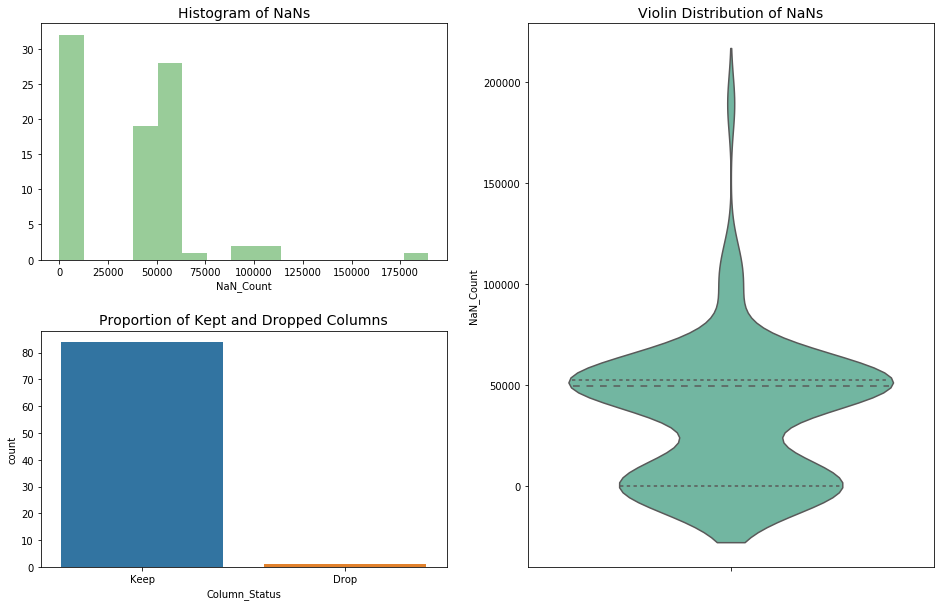

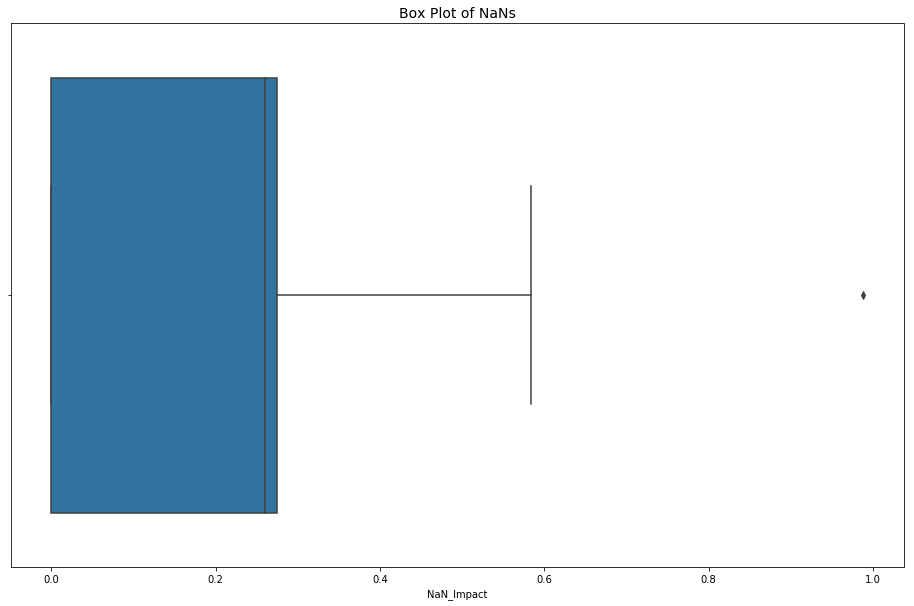

Results from Reduction:
	Outliers with less than -13,389.799999999996 or more than 113,243.79999999999 null count were removed.
	Outliers with less than -6.99% or more than 59.09% impact were removed.
	There is a total of 191,652 rows and 85 columns.
	1 column was/were removed.



,Dropped List
0,TITEL_KZ


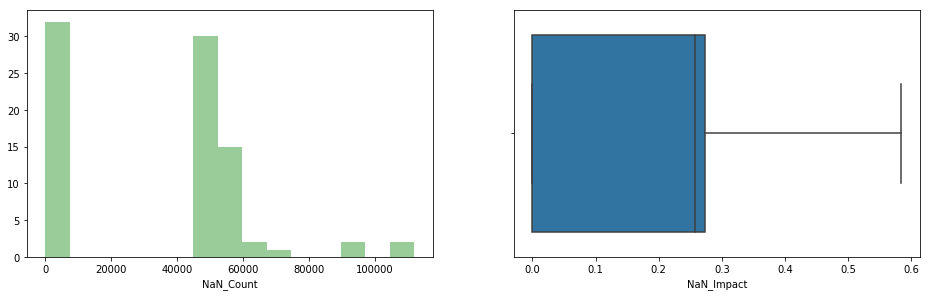

------------------------------------------------------------------------------------------------------------------------------------------------------


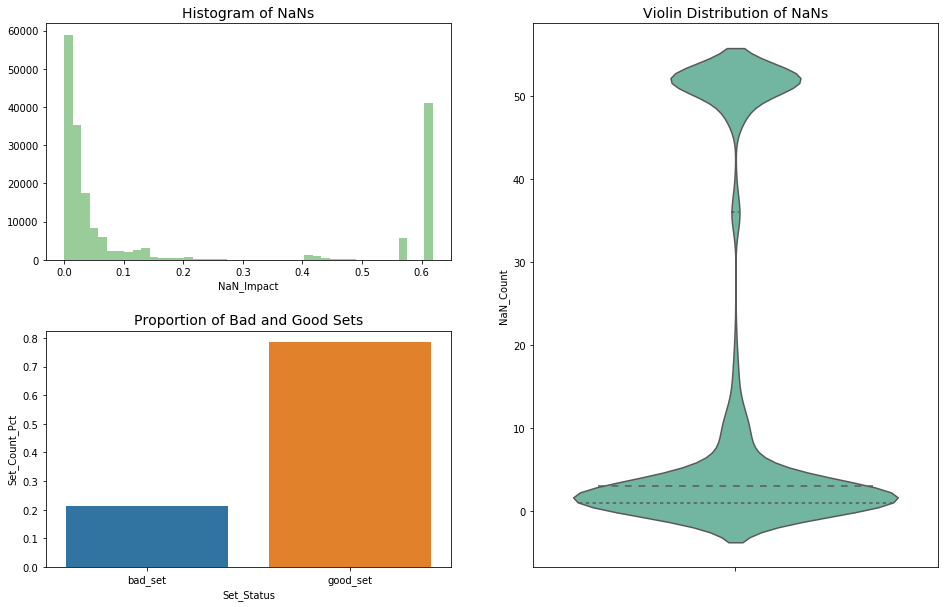

,NaN_Count,NaN_Impact
count,191652.00,191652.00
mean,15.25,0.18
std,21.23,0.25
min,0.00,0.00
25%,1.00,0.01
50%,3.00,0.04
75%,36.00,0.43
max,52.00,0.62


Skewness:


NaN_Count   1.06
dtype: float64

,Set_Status,Set_Count,Set_Count_Pct
0,bad_set,40965,0.21
1,good_set,150687,0.79


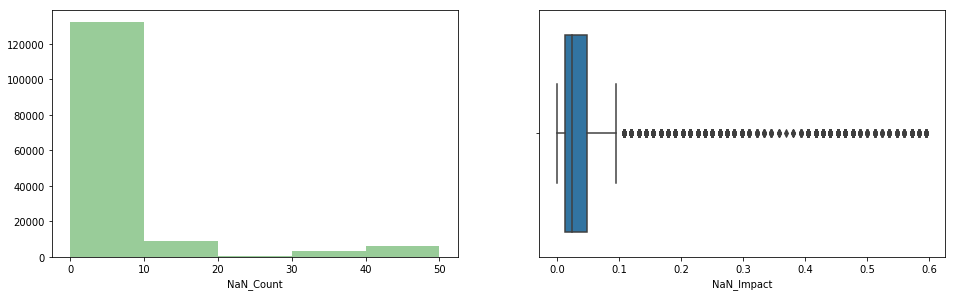

------------------------------------------------------------------------------------------------------------------------------------------------------


,data_type,unique_count
ANREDE_KZ,float64,2
OST_WEST_KZ,object,2
VERS_TYP,float64,2
SOHO_KZ,float64,2
GREEN_AVANTGARDE,float64,2
AGER_TYP,float64,3
NATIONALITAET_KZ,float64,3
SHOPPER_TYP,float64,4
LP_STATUS_GROB,float64,5
LP_FAMILIE_GROB,float64,5


,data_type,unique_count
OST_WEST_KZ,object,2
AGER_TYP,float64,3
NATIONALITAET_KZ,float64,3
SHOPPER_TYP,float64,4
LP_STATUS_GROB,float64,5
LP_FAMILIE_GROB,float64,5
FINANZTYP,float64,6
ZABEOTYP,float64,6
KK_KUNDENTYP,float64,6
GEBAEUDETYP,float64,6


There are 20 categorical variables. 
There are 16 categories with greater than 2 unique or non-numeric values.
16 columns will be encoded.
The dataframe passed had 84 columns in total.
There will be 68 unencoded columns.


Endoding: OST_WEST_KZ
Endoding: AGER_TYP
Endoding: NATIONALITAET_KZ
Endoding: SHOPPER_TYP
Endoding: LP_STATUS_GROB
Endoding: LP_FAMILIE_GROB
Endoding: FINANZTYP
Endoding: ZABEOTYP
Endoding: KK_KUNDENTYP
Endoding: GEBAEUDETYP
Endoding: CJT_GESAMTTYP
Endoding: CAMEO_DEUG_2015
Endoding: LP_STATUS_FEIN
Endoding: LP_FAMILIE_FEIN
Endoding: GFK_URLAUBERTYP
Endoding: CAMEO_DEU_2015

Status: 
Uencoded columns: 68	rows: 150,687
ToEncode columns: 16	rows: 150,687
Encoded columns: 151	rows: 150,687


,PRAEGENDE_JUGENDJAHRE,FINANZ_SPARER
0,4.00,1.00
1,nan,1.00
2,4.00,1.00
3,1.00,1.00
4,8.00,1.00


*FINANZ_SPARER was converted to FINAZ_AUSGEBEN inversively


,PRAEGENDE_JUGENDJAHRE,FINAZ_AUSGEBEN
0,50s - milk bar / Individualisation (Avantgarde,very low money-spender
1,NaN,very low money-spender
2,50s - milk bar / Individualisation (Avantgarde,very low money-spender
3,40s - war years (Mainstream,very low money-spender
4,70s - family orientation (Mainstream,very low money-spender


Endoding: PRAEGENDE_JUGENDJAHRE_AUSGEBEN
Status:
	New feature unique count: 96
	Encoding column count: 96
	Encoded rows: 150,687

The final column count: 315


In [136]:
customer_clean, customer_split = clean_data(customers, col_treshold=.60)

In [137]:
print(f'Number of null values in customer_clean: {customer_clean.isna().sum().sum()}')

Number of null values in customer_clean: 574135


In [138]:
customer_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,PRAEGENDE_JUGENDJAHRE_AUSGEBEN_86,PRAEGENDE_JUGENDJAHRE_AUSGEBEN_87,PRAEGENDE_JUGENDJAHRE_AUSGEBEN_88,PRAEGENDE_JUGENDJAHRE_AUSGEBEN_89,PRAEGENDE_JUGENDJAHRE_AUSGEBEN_90,PRAEGENDE_JUGENDJAHRE_AUSGEBEN_91,PRAEGENDE_JUGENDJAHRE_AUSGEBEN_92,PRAEGENDE_JUGENDJAHRE_AUSGEBEN_93,PRAEGENDE_JUGENDJAHRE_AUSGEBEN_94,PRAEGENDE_JUGENDJAHRE_AUSGEBEN_95
0,4.00,1.00,5.00,1.00,5.00,1.00,2.00,2.00,nan,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,4.00,1.00,5.00,1.00,5.00,1.00,3.00,2.00,nan,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,4.00,2.00,5.00,1.00,5.00,1.00,4.00,4.00,nan,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,4.00,1.00,5.00,1.00,5.00,2.00,1.00,2.00,nan,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,3.00,1.00,3.00,1.00,4.00,4.00,5.00,2.00,1960.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,Null,Count
ALTERSKATEGORIE_GROB,0,40965
ANREDE_KZ,0,40965
CJT_GESAMTTYP,1,40964
FINANZ_MINIMALIST,0,40965
FINANZ_SPARER,0,40965
FINANZ_VORSORGER,0,40965
FINANZ_ANLEGER,0,40965
FINANZ_UNAUFFAELLIGER,0,40965
FINANZ_HAUSBAUER,0,40965
FINANZTYP,0,40965


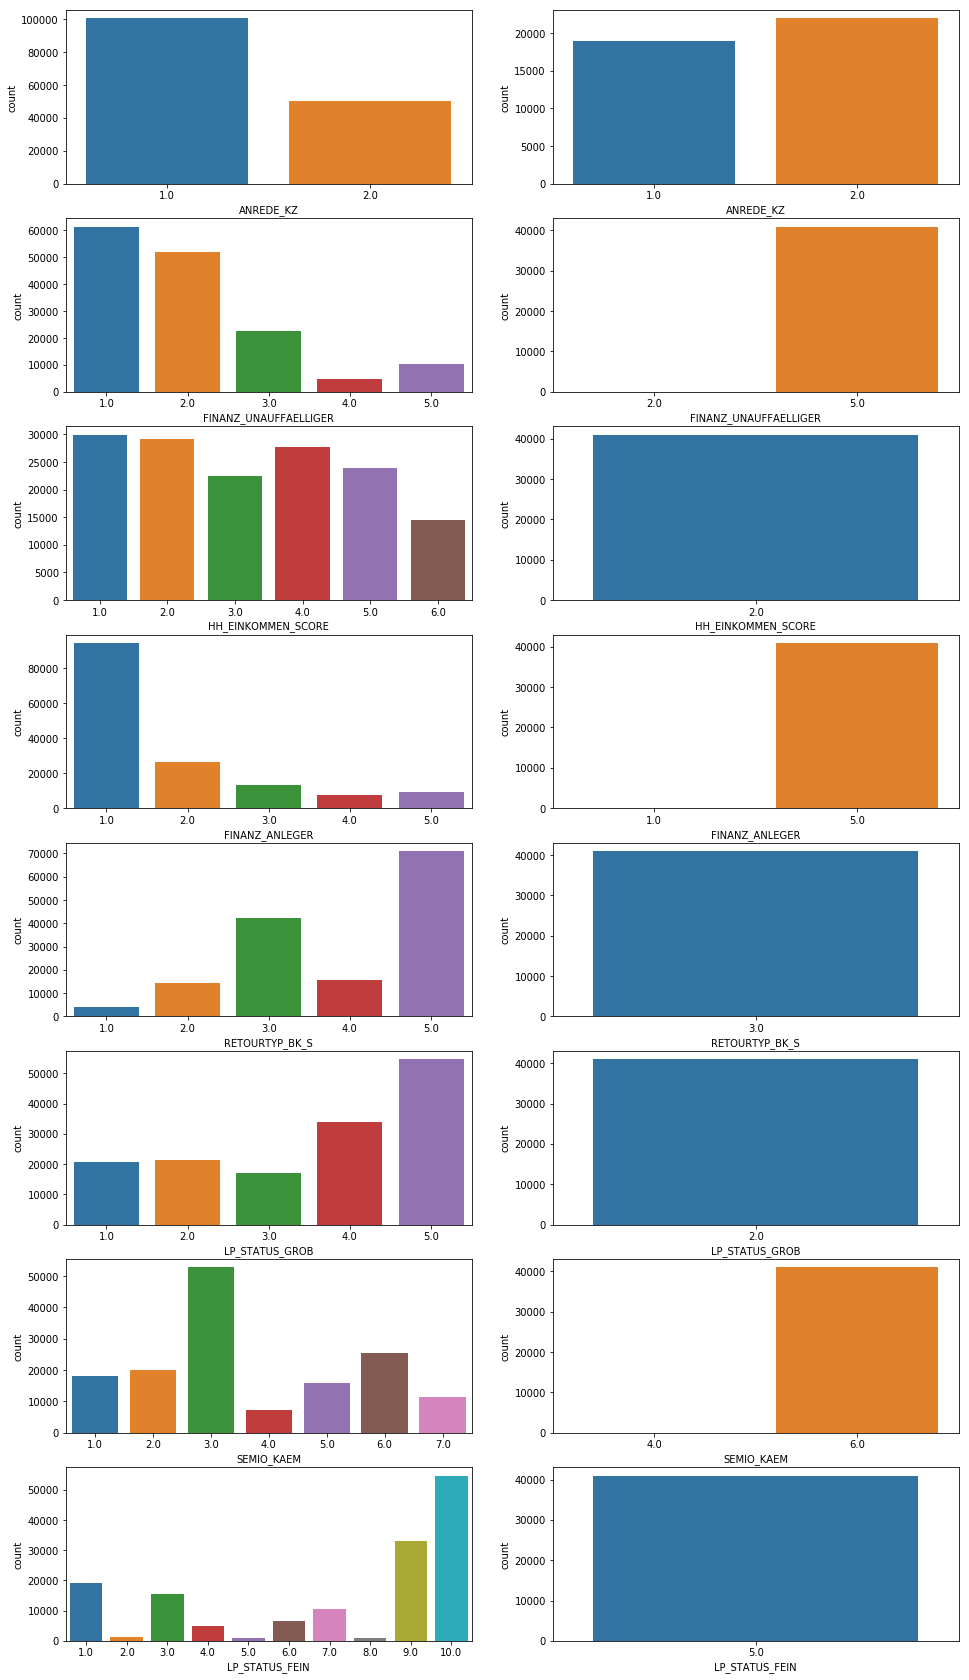

In [139]:
target_columns = get_good_bad_targets(customer_split[1])
plot_good_bad(customer_split[0], customer_split[1], target=target_columns)

## 3. Uencoded Data Imputing and Cleaning

### 1. Assess NaN Removals by Percentage Impact
---

In [140]:
pd.options.display.float_format = '{:2.2%}'.format
frame_nulls_left \
    = pd.DataFrame(customer_clean.isna().sum(), columns=['Null_Counts'])\
        .query("Null_Counts > 0")\
        .sort_values('Null_Counts')
frame_nulls_left['Null_Impact'] = frame_nulls_left.Null_Counts / customer_clean.shape[0]
display_html('All Columns and Null Impact')
display(frame_nulls_left\
            .merge(feat_info[['attribute', 'type']]\
                   .set_index('attribute'),
                          left_index=True, right_index=True, how='left')\
            .sort_values('Null_Impact', ascending=False))

,Null_Counts,Null_Impact,type
KBA05_BAUMAX,68570,45.50%,mixed
GEBURTSJAHR,52059,34.55%,numeric
ALTER_HH,27782,18.44%,interval
REGIOTYP,19099,12.67%,ordinal
KKK,19099,12.67%,ordinal
W_KEIT_KIND_HH,15972,10.60%,ordinal
KBA05_GBZ,15017,9.97%,ordinal
KBA05_ANTG4,15015,9.96%,ordinal
KBA05_ANTG1,15015,9.96%,ordinal
MOBI_REGIO,15015,9.96%,ordinal


In [141]:
pd.options.display.float_format = '{:2.4f}'.format
frame_nulls_left.sum()

Null_Counts   574135.0000
Null_Impact        3.8101
dtype: float64

In [142]:
drop_customer_cleanrows = customer_clean.shape[0] - customer_clean.dropna(axis=0, how='any').shape[0]
print(f'Droping all will reduce {drop_customer_cleanrows/customer_clean.shape[0]:2.2%} of the dataset.')

Droping all will reduce 71.35% of the dataset.


>**Remove all conclussion**: Removing all rows with nulls will result at most 100% of dataset removal, which is quite significant. It dependes on which null values are shared null values row by row, which I don't think is possible. In fact, only 77.47% will be reduced. That is almost all the data.

In [143]:
frame_keep_nulls\
    = frame_nulls_left[['Null_Impact']]\
        .sort_values('Null_Impact', ascending=False)\
        .cumsum()\
        .pct_change()\
        .query("Null_Impact > 0.02 or Null_Impact != Null_Impact")\
                .merge(feat_info[['attribute', 'type']]\
                       .set_index('attribute'),
                              left_index=True, right_index=True, how='left')
display_html('Rows to keep per These Columns and Null Impact % Change')
display(frame_keep_nulls.rename(columns={'Null_Impact': 'Null_ImpactCh'}))

,Null_ImpactCh,type
KBA05_BAUMAX,nan,mixed
GEBURTSJAHR,0.7592,numeric
ALTER_HH,0.2303,interval
REGIOTYP,0.1287,ordinal
KKK,0.1140,ordinal
W_KEIT_KIND_HH,0.0856,ordinal
KBA05_GBZ,0.0741,ordinal
KBA05_ANTG4,0.0690,ordinal
KBA05_ANTG1,0.0645,ordinal
MOBI_REGIO,0.0606,ordinal


>Note: The percentage change is significat for the above features.

In [144]:
remove_nan = frame_nulls_left[['Null_Impact']]\
    .sort_values('Null_Impact', ascending=False)\
    .cumsum()\
    .pct_change()\
    .query("Null_Impact < 0.02").index
print(f'Removing Row with NaNs for the following features: {list(remove_nan)}')
frame_nulls_left.query(f"index == {list(remove_nan)}").sum()

Removing Row with NaNs for the following features: ['BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'MIN_GEBAEUDEJAHR', 'GEBAEUDETYP_RASTER', 'WOHNLAGE', 'HEALTH_TYP', 'VERS_TYP', 'KONSUMNAEHE', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S', 'HH_EINKOMMEN_SCORE', 'ALTERSKATEGORIE_GROB']


Null_Counts   107764.0000
Null_Impact        0.7152
dtype: float64

In [145]:
subset = list(remove_nan)
remove_shape = customer_clean.dropna(axis=0, how='any', subset=subset).shape[0]
remove_pct = 1-remove_shape/customer_clean.shape[0]
print(f'Removing all rows from subset will end up reducing the dataset by {remove_pct:2.2%}')

Removing all rows from subset will end up reducing the dataset by 9.55%


>**Remove low percentage impact conclussion**: Removing rows with NaNs out of these ones makes sense since the removal is insignificant.

In [146]:
frame_nulls_left.query(f"index != {list(remove_nan)}").sum()

Null_Counts   466371.0000
Null_Impact        3.0950
dtype: float64

>**Keep high percentage impact conclussion**: Assess imputation of features with high percentage impact.

### 2. Assessing the Ideal Imputing Method
---

In [147]:
head = 5 # change number to see more data value descriptions
display_html('Value Keys for Features with More than 5% NaNs')
data_dict_view\
    .query(f"ColumnName == {list(frame_keep_nulls.index)}")\
    .merge(feat_info[['attribute', 'type']]\
           .rename(columns={'attribute':'ColumnName'}), on='ColumnName', how='left')\
    .head(head)

,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta,type
0,1.11,9,single independent persons,LP_LEBENSPHASE_FEIN,LEBENSPHASE_FEIN,Life stage,NaN,mixed
1,1.11,1,single low-income earners of younger age,LP_LEBENSPHASE_FEIN,LEBENSPHASE_FEIN,Life stage,NaN,mixed
2,1.11,2,single low-income earners of middle age,LP_LEBENSPHASE_FEIN,LEBENSPHASE_FEIN,Life stage,NaN,mixed
3,1.11,3,single average earners of younger age,LP_LEBENSPHASE_FEIN,LEBENSPHASE_FEIN,Life stage,NaN,mixed
4,1.11,4,single average earners of middle age,LP_LEBENSPHASE_FEIN,LEBENSPHASE_FEIN,Life stage,NaN,mixed


#### 2.1 Numerical Assessment
---
---

In [148]:
data_dict_coldesc.query(f"type == 'numeric' and Kept == True and ColumnName == {list(frame_keep_nulls.index)}")

,key,ColumnName,ColumnShortName,ColNameDescription,Kept,type
50,3.1,ANZ_HAUSHALTE_AKTIV,HAUSHALTE_AKTIV,Number of households in the building,True,numeric
51,3.2,ANZ_HH_TITEL,HH_TITEL,Number of professional academic title holders ...,True,numeric
74,8.1,KBA13_ANZAHL_PKW,ANZAHL_PKW,Number of cars in the PLZ8 region,True,numeric


In [149]:
pd.options.display.float_format = '{:2.2f}'.format
azdias[['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'ANZ_HH_TITEL']].describe()

,ANZ_HAUSHALTE_AKTIV,KBA13_ANZAHL_PKW,ANZ_HH_TITEL
count,695464.00,695464.00,695464.00
mean,8.40,616.21,0.04
std,15.37,337.06,0.31
min,1.00,0.00,0.00
25%,2.00,382.00,0.00
50%,4.00,546.00,0.00
75%,10.00,773.00,0.00
max,536.00,2300.00,20.00


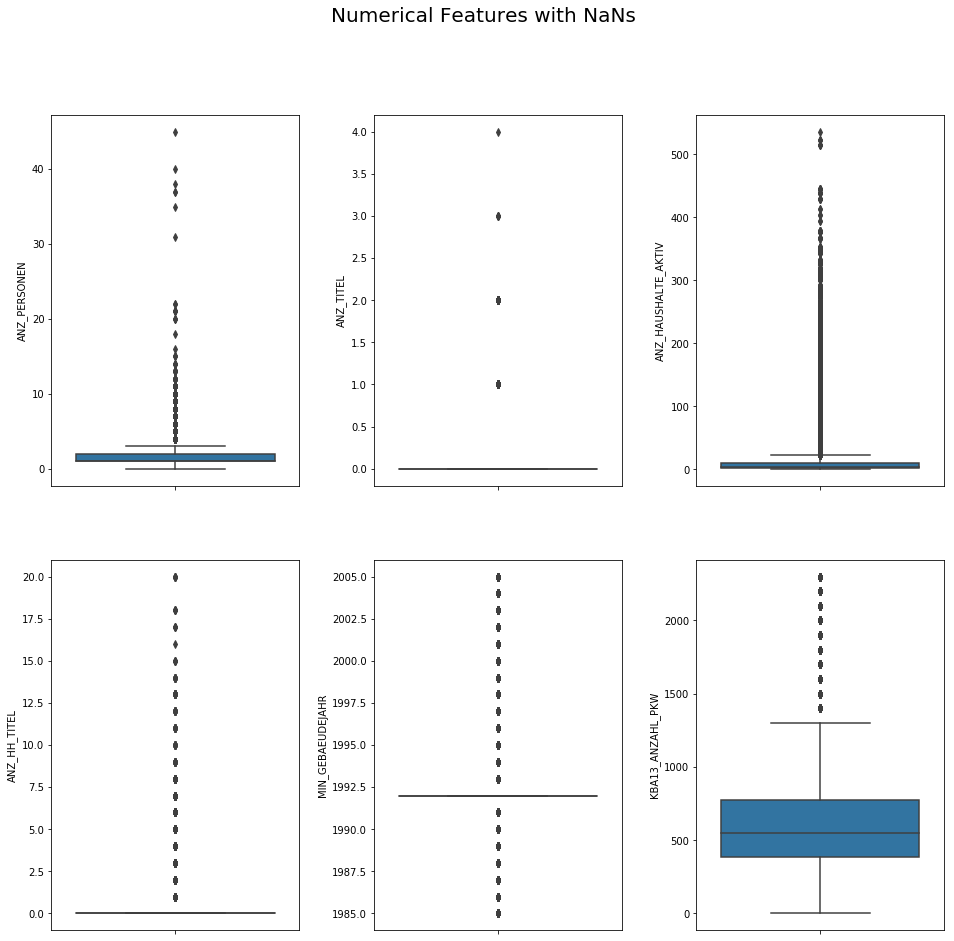

In [150]:
fig1, ax = plt.subplots(ncols=3, nrows=2, figsize=(16, 15))

ax_list = []

for x in range(2):
    for j in range(3):
        ax_list.append(ax[x, j])
        
ax00, ax01, ax02, ax10, ax11, ax12 = ax_list


plt.subplots_adjust(wspace=.3)
plt.suptitle('Numerical Features with NaNs', size=20)

sns.boxplot(y='ANZ_PERSONEN', data=azdias, ax=ax00)
sns.boxplot(y='ANZ_TITEL', data=azdias, ax=ax01)
sns.boxplot(y='ANZ_HAUSHALTE_AKTIV', data=azdias, ax=ax02)
sns.boxplot(y='ANZ_HH_TITEL', data=azdias, ax=ax10)
sns.boxplot(y='MIN_GEBAEUDEJAHR', data=azdias, ax=ax11)
sns.boxplot(y='KBA13_ANZAHL_PKW', data=azdias, ax=ax12)
plt.show()

> **Numerical Imputing Conclussion**: 
> - I am imputing the median for numerical feature number 1. This feaatures have significant NaN percentage impact, thus the rows will be kept.
> - I will use the median to inputate values for all numerical features because they are all highly skewed, except for KBA13_ANZAHL_PKW, which is only a bit skewed due to outliers.
---

#### 2.2 Ordinal, Mixed, and Categorical Assessment
---
---

In [151]:
frame_nulls_left

,Null_Counts,Null_Impact
ALTERSKATEGORIE_GROB,240,0.00
HH_EINKOMMEN_SCORE,2967,0.02
ONLINE_AFFINITAET,3212,0.02
RETOURTYP_BK_S,3212,0.02
WOHNDAUER_2008,5632,0.04
ANZ_TITEL,5632,0.04
ANZ_PERSONEN,5632,0.04
SOHO_KZ,5632,0.04
KONSUMNAEHE,5687,0.04
VERS_TYP,8025,0.05


In [152]:
def show_cat_plots():
    fig1, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

    ax11, ax12, ax21, ax22 = ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]

    plt.suptitle('Count Plots of Top 4 Non-Numerical Features', size=20)
    
    if azdias.isna().sum().sum() > 0: i = 0
    else: i = 1

    # draw plots
    sns.countplot(x=customer_clean.KBA05_BAUMAX.fillna(0), ax=ax11)
    ax11.vlines(x=customer_clean.KBA05_BAUMAX.median()-i, ymin=0, ymax=customer_clean.groupby('KBA05_BAUMAX').size().max())
    sns.violinplot(y=customer_clean.GEBURTSJAHR, ax=ax12)
    ax12.hlines(y=customer_clean.GEBURTSJAHR.median(), xmin=-.5, xmax=.5)
    sns.countplot(x=customer_clean.ALTER_HH.fillna(0), ax=ax21)
    ax21.vlines(x=customer_clean.ALTER_HH.median()-i, ymin=0, ymax=customer_clean.groupby('ALTER_HH').size().max())
    sns.countplot(x=customer_clean.REGIOTYP.fillna(0), ax=ax22)
    ax22.vlines(x=customer_clean.REGIOTYP.median()-i, ymin=0, ymax=customer_clean.groupby('REGIOTYP').size().max())

    plt.show()

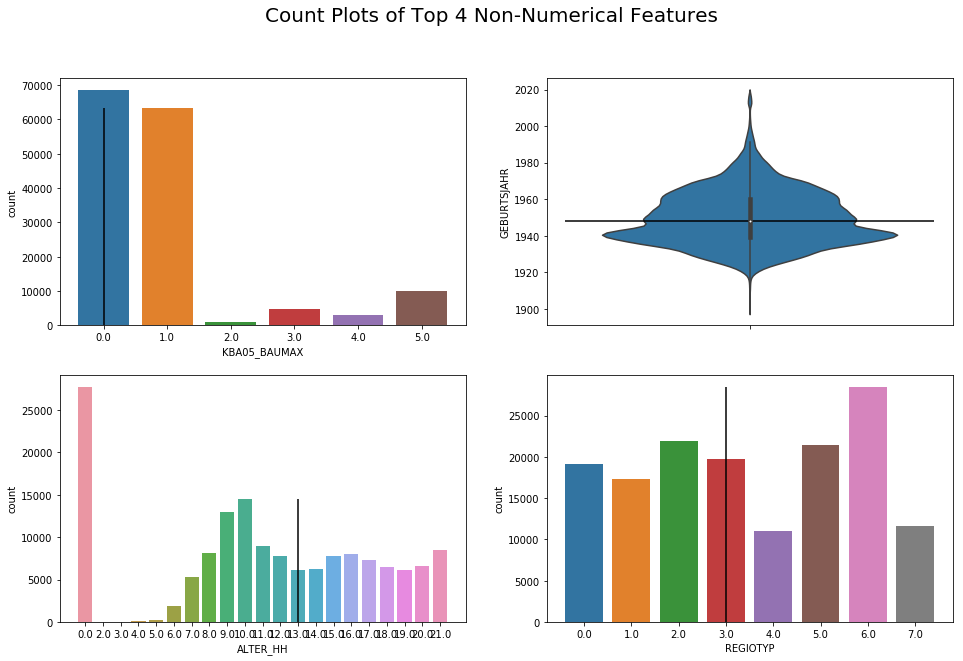

In [153]:
show_cat_plots()

### 3. Imputate or/and Remove NaN values as Assessed
---

#### 3.1 Remove NaNs
---
---

In [154]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
subset = list(remove_nan)

In [155]:
current_rows = customer_clean.shape[0]
customer_clean.dropna(axis=0, how='any', subset=subset, inplace=True)
reduced_rows =  customer_clean.shape[0]
drop_rows = current_rows-reduced_rows
print(f'Customer was reduced by {drop_rows:,}, which is a {drop_rows/current_rows:2.2%} reduction.')

Customer was reduced by 14,385, which is a 9.55% reduction.


#### 3.2 Impute Rounded Medians
---
---

In [156]:
from sklearn.impute import SimpleImputer

In [157]:
subset = list(frame_nulls_left.query(f"index != {list(remove_nan)}").index)

In [158]:
customer_clean.loc[:, subset].dtypes

ORTSGR_KLS9            float64
ARBEIT                 float64
RELAT_AB               float64
CAMEO_INTL_2015        float64
LP_LEBENSPHASE_GROB    float64
LP_LEBENSPHASE_FEIN    float64
KBA13_ANZAHL_PKW       float64
ANZ_HH_TITEL           float64
ANZ_HAUSHALTE_AKTIV    float64
PLZ8_GBZ               float64
PLZ8_HHZ               float64
PLZ8_BAUMAX            float64
PLZ8_ANTG4             float64
PLZ8_ANTG3             float64
PLZ8_ANTG2             float64
PLZ8_ANTG1             float64
KBA05_ANTG1            float64
MOBI_REGIO             float64
KBA05_ANTG4            float64
KBA05_ANTG2            float64
KBA05_ANTG3            float64
KBA05_GBZ              float64
W_KEIT_KIND_HH         float64
KKK                    float64
REGIOTYP               float64
ALTER_HH               float64
GEBURTSJAHR            float64
KBA05_BAUMAX           float64
dtype: object

In [159]:
customer_clean.loc[:, subset].shape

(136302, 28)

In [160]:
pd.DataFrame(customer_clean.isna().sum(), columns=['NaNs']).query("NaNs > 0")

,NaNs
GEBURTSJAHR,43124
LP_LEBENSPHASE_FEIN,6084
LP_LEBENSPHASE_GROB,6084
ALTER_HH,20491
W_KEIT_KIND_HH,7645
ANZ_HAUSHALTE_AKTIV,2360
ANZ_HH_TITEL,2140
CAMEO_INTL_2015,584
KBA05_ANTG1,5848
KBA05_ANTG2,5848


In [161]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
customer_clean = pd.DataFrame(imp_median.fit_transform(customer_clean), columns=customer_clean.columns)

In [162]:
pd.options.display.max_rows = 300
pd.DataFrame([imp_median.statistics_, customer_clean.columns]).T\
    .rename(columns={0:'Imputated Median', 1:'Feature'})\
    .query(f"Feature == {subset}")

,Imputated Median,Feature
8,1948.00,GEBURTSJAHR
11,23.00,LP_LEBENSPHASE_FEIN
12,6.00,LP_LEBENSPHASE_GROB
30,13.00,ALTER_HH
34,5.00,W_KEIT_KIND_HH
36,1.00,ANZ_HAUSHALTE_AKTIV
37,0.00,ANZ_HH_TITEL
41,24.00,CAMEO_INTL_2015
42,2.00,KBA05_ANTG1
43,1.00,KBA05_ANTG2


> Note: There was no need to round the medians since each imputation matches perfectly with the data dictionary.

In [163]:
print(f'Validating Customer Shape Again: {customer_clean.shape}')

Validating Customer Shape Again: (136302, 314)


In [164]:
print(f'Validating NaNs: {customer_clean.isna().sum().sum()}'+
      f"\n{'Data is ready to scale, pca, kemans' if customer_clean.isna().sum().sum() == 0 else ''}")

Validating NaNs: 0
Data is ready to scale, pca, kemans


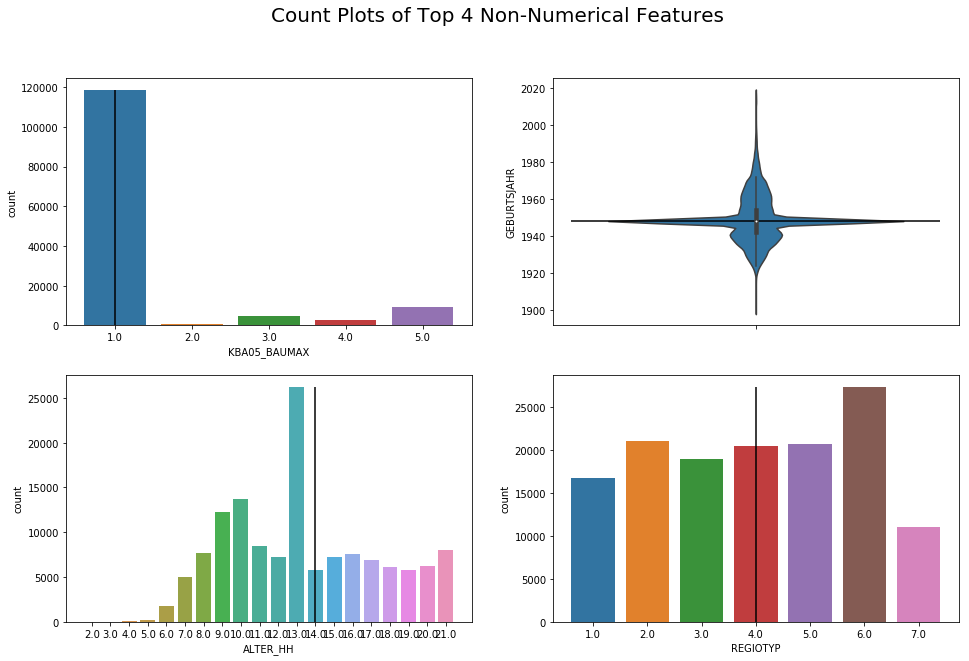

In [165]:
show_cat_plots()

## 3. Scaling
---

In [166]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
X = do_standarscaler(customer_clean)
#n_component = find_n_component(X, customer_clean)
n_component = 138

Time to process: 0:00:01.823137


## 4. Principal Component Analysis
---

In [167]:
customer_pca, X_pca = do_pca(n_component, X)

Time to process: 0:00:08.558255


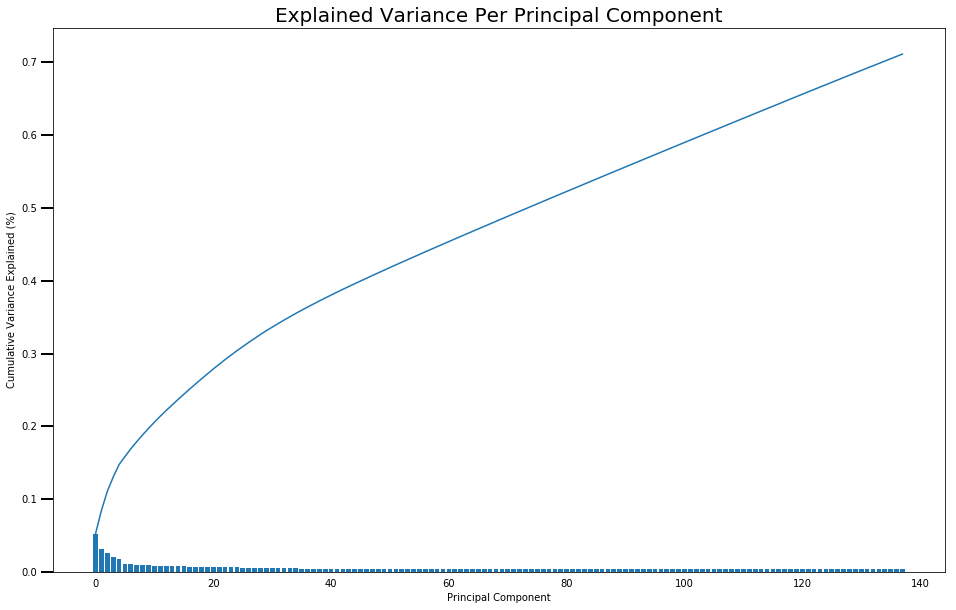

In [168]:
scree_plot(customer_pca)

In [169]:
customer_components = frame_principal_components(customer_clean, customer_pca)

## 5. Kmeans
---

In [170]:
#n_clusters, centers, scores = find_clusters(X_pca)
#plot_clusters(centers, scores)

In [171]:
customer_kmeans, customer_true_labels, customer_labels, customer_centroids = do_kmean(X_pca, n_clusters)

Time to find cluster: 0:00:32.839447


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [172]:
def get_component_value_key(components, component_name):
    index_clear_map = [f'_{x}' for x in range(20)]
    component = get_principal_component(components, component_name)
    component\
        = component\
            .query("Rank <= 1 or Rank > Rank.max() - 1")\
            .reset_index()\
            .rename(columns={'index':'Features'})
    component['Feat_Key']\
        = component\
            .Features\
            .apply(lambda x: x[:-2] if x[-2:] in (index_clear_map) else x)
    
    display(component)
    
    display(data_dict_view\
        .query(f"ColumnName=={list(component.Feat_Key)}")\
        .sort_values(['key', 'ColumnName', 'value_key'])\
        .query("ValueMaps != 'unknown'"))

In [173]:
def frame_cluster_centroid(keman_cluster_centers):
    
    # get first 3 principal components and adjust index to reflect component number
    centroids = pd.DataFrame(keman_cluster_centers).T.iloc[:3, :]
    centroids.columns = centroids.columns + 1
    centroids.set_axis(centroids.index + 1)
    
    # melt dataframe
    centroids \
        = centroids\
            .reset_index()\
            .rename(columns={'index':'PC #'})\
            .melt(id_vars=['PC #'], var_name='Cluster', value_name='Centroid')

    # rename numbers for components and clusters
    centroids['ClusterId'] = centroids.Cluster
    centroids.Cluster = centroids.Cluster.apply(lambda x: f'Cluster_{x}')
    centroids['PC #'] = centroids['PC #'].apply(lambda x: f'PC_{x}')
    centroids['Abs_Centroid'] = centroids.Centroid.abs()
    
    return centroids

In [174]:
def get_key_centroids(centroids):
    centroids \
        = centroids\
            .query(f"ClusterId == {ClusterId}")\
            .copy()
    centroids.loc[:, 'Rank'] \
        = centroids\
            .groupby('ClusterId')['Abs_Centroid']\
            .rank(ascending=False)\
            .astype(int)

    return centroids.query("Rank == 1")

## 1. Cluster Representation Significance
---

In [175]:
# create cluster dataframes
cluster_customer = pd.DataFrame({'clusters': customer_true_labels, 'labels': customer_labels})
cluster_azdias = pd.DataFrame({'clusters': azdias_true_labels, 'labels': azdias_labels})

In [176]:
# combine and unpivot dataframes for populations
population_clusters = \
    pd.concat([cluster_customer[['clusters']].rename(columns={'clusters':'customer'}), 
               cluster_azdias[['clusters']].rename(columns={'clusters':'azdias'})], 
              axis=1)\
        .melt(value_vars=['customer', 'azdias'], var_name='Population', value_name='Cluster')

# add 1 to clusters to represent clusters from 1 to n
population_clusters.Cluster = population_clusters.Cluster.apply(lambda x: x + 1)

In [177]:
population_clusters = pd.DataFrame(population_clusters.groupby(['Population', 'Cluster']).size(), columns=['Frequency']).reset_index()

In [178]:
azdias_bad_cluster = pd.DataFrame({'Population': ['azdias'], 
                           'Cluster': 8., 
                           'Frequency':azdias_bad.shape[0]})
customer_bad_cluster = pd.DataFrame({'Population': ['customer'], 
                             'Cluster': 8., 
                             'Frequency': customer_split[1].shape[0]})
population_clusters = pd.concat([population_clusters, azdias_bad_cluster, customer_bad_cluster], ignore_index=True)

In [179]:
population_clusters\
    .loc[population_clusters.Population=='azdias', 'Freq %'] \
    = population_clusters.query("Population == 'azdias'").Frequency/azdias.shape[0]
population_clusters\
    .loc[population_clusters.Population=='customer', 'Freq %'] \
    = population_clusters.query("Population == 'customer'").Frequency/customer_clean.shape[0]

In [180]:
population_clusters.groupby('Population').sum().reset_index()

,Population,Cluster,Frequency,Freq %
0,azdias,36.00,889576,1.28
1,customer,36.00,177267,1.30


In [181]:
# geting population cluster groups and pivoting table to get significances
population_cluster_freqpct = population_clusters\
    .pivot_table(index='Cluster', columns='Population', values='Freq %')\
    .reset_index()\
    .rename_axis('', axis=1)

condition = population_cluster_freqpct.azdias < population_cluster_freqpct.customer
population_cluster_freqpct\
    .loc[condition, 'Represented'] = 'Over'
population_cluster_freqpct\
    .loc[~condition, 'Represented'] = 'Under'
population_cluster_freqpct['Significance'] \
    = population_cluster_freqpct.customer/population_cluster_freqpct.azdias-1
population_cluster_freqpct.loc[population_cluster_freqpct.Represented == 'Under', 'SigRank'] \
    = population_cluster_freqpct.query("Represented == 'Under'").Significance.rank()
population_cluster_freqpct.loc[population_cluster_freqpct.Represented == 'Over', 'SigRank'] \
    = population_cluster_freqpct.query("Represented == 'Over'").Significance.rank(ascending=0)
population_cluster_freqpct.SigRank = population_cluster_freqpct.SigRank.astype(int)
population_cluster_freqpct.Cluster = population_cluster_freqpct.Cluster.astype(int)
display_html('Cluster Representation & Significance DataFrame')
population_cluster_freqpct

,Cluster,azdias,customer,Represented,Significance,SigRank
0,1,0.14,0.08,Under,-0.40,2
1,2,0.15,0.19,Over,0.29,2
2,3,0.12,0.11,Under,-0.14,3
3,4,0.20,0.18,Under,-0.07,4
4,5,0.15,0.25,Over,0.67,1
5,6,0.11,0.03,Under,-0.70,1
6,7,0.13,0.15,Over,0.16,3
7,8,0.28,0.30,Over,0.08,4


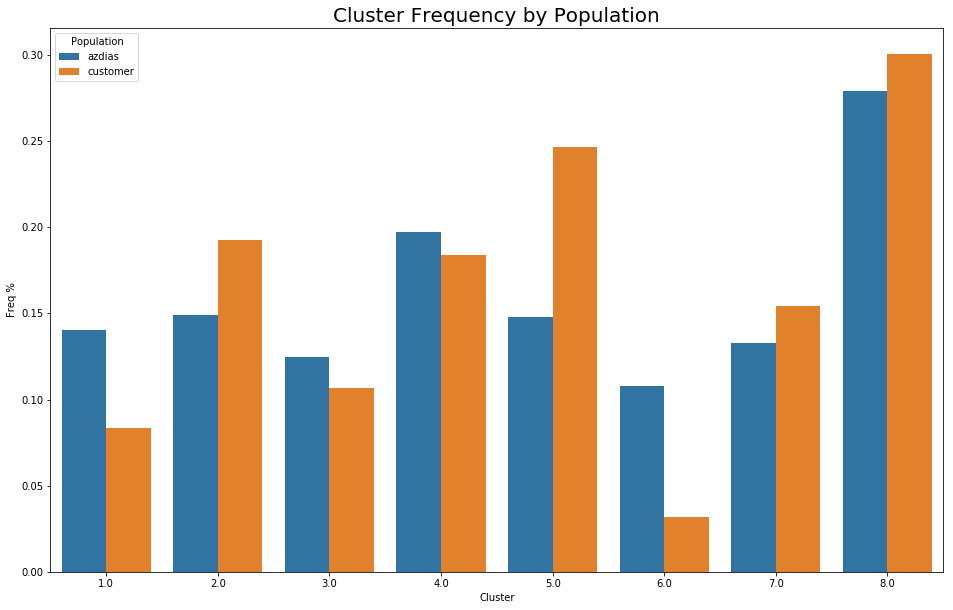

In [182]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population
plt.figure(figsize=(16, 10))
sns.barplot(x='Cluster', y='Freq %', hue='Population', data=population_clusters)
plt.title('Cluster Frequency by Population', size=20)
plt.show()

In [183]:
display_html('Cluster Representation Significance Findings:')
xx = population_cluster_freqpct.query("SigRank == 1")[['Cluster', 'Represented']]
xx = list(pd.DataFrame([xx[x].values for x in xx]).T.set_index(0).to_dict().values())[0]

print(f'\t• Cluster {list(xx.keys())[1]} is the most {list(xx.values())[1].lower()}-represented cluster\n\n'+\
      f'\t• Cluster {list(xx.keys())[0]} is the most {list(xx.values())[0].lower()}-represented cluster')
ClusterId = tuple(xx.keys())

	• Cluster 6 is the most under-represented cluster

	• Cluster 5 is the most over-represented cluster


## 2. Over-represented Cluster Analysis
---

In [184]:
pd.DataFrame(customer_kmeans.cluster_centers_).iloc[:, :3]

,0,1,2
0,-1.43,-0.73,1.72
1,6.35,-0.01,0.61
2,-3.03,4.66,0.45
3,-2.12,-0.08,-2.25
4,-2.26,-2.09,2.05
5,2.59,8.53,1.03
6,0.55,-1.17,-2.81


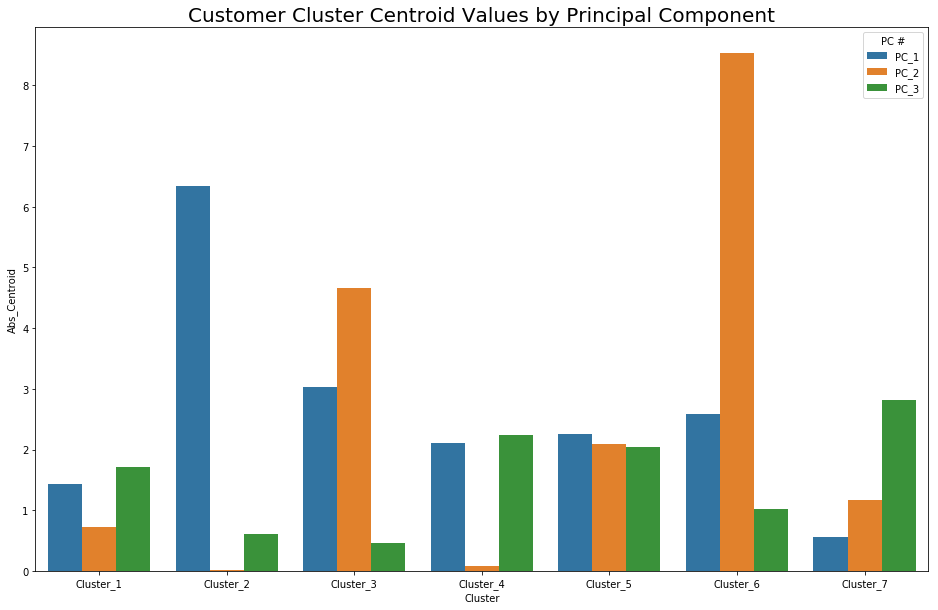

In [185]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
customer_centroids = frame_cluster_centroid(customer_kmeans.cluster_centers_)
plt.figure(figsize=(16, 10))
sns.barplot(x='Cluster', y='Abs_Centroid', hue='PC #', data=customer_centroids)
plt.title('Customer Cluster Centroid Values by Principal Component', size=20)
plt.show()

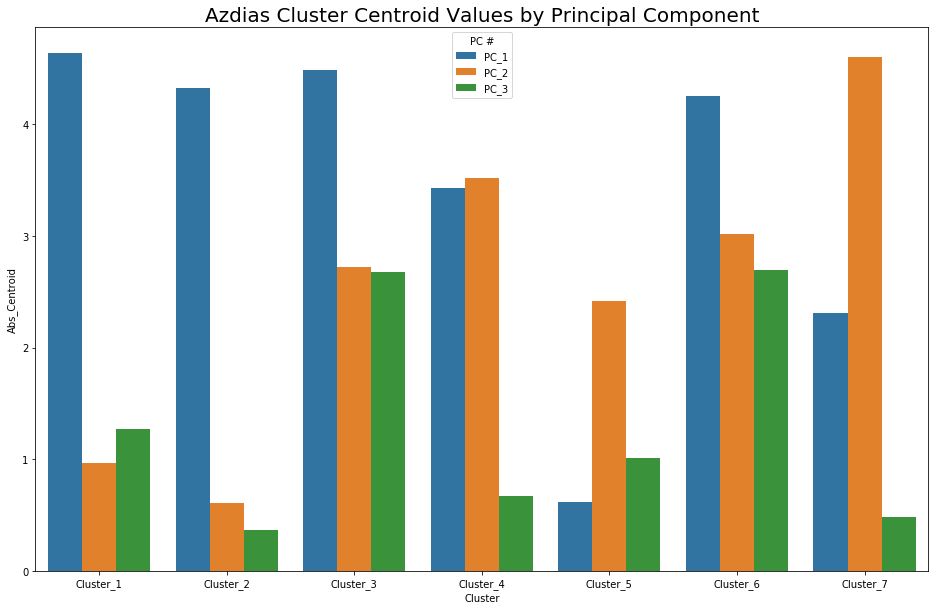

In [186]:
azdias_centroids = frame_cluster_centroid(azdias_kmeans.cluster_centers_)
plt.figure(figsize=(16, 10))
sns.barplot(x='Cluster', y='Abs_Centroid', hue='PC #', data=azdias_centroids)
plt.title('Azdias Cluster Centroid Values by Principal Component', size=20)
plt.show()

In [187]:
display_html('Over-represented Findings:')
key_customer_centroids = get_key_centroids(customer_centroids)
customer_cluster = list(key_customer_centroids.ClusterId)[1]
customer_component = list(key_customer_centroids['PC #'])[1][-1:]
print(f'\t• For customers, we can see that cluster {customer_cluster}'+\
      f" has more weight in the principal component {customer_component}.")

key_azdias_centroids = get_key_centroids(azdias_centroids)
azdias_cluster = list(key_azdias_centroids.ClusterId)[1]
azdias_component = list(key_azdias_centroids['PC #'])[1][-1:]
print(f'\n\t• In contrast, for azdias we can see that cluster {azdias_cluster}'+\
      f" has more weight in the principal component {azdias_component}.")

	• For customers, we can see that cluster 6 has more weight in the principal component 2.

	• In contrast, for azdias we can see that cluster 6 has more weight in the principal component 1.


Theh kind of people that are under-represented in the customer data compare to the general population are  

In [188]:
display_html('Customer Feature Descriptions')
print(f'This subset (cluster {customer_cluster}) is driven mostly by principal component {customer_component}.\n')
get_component_value_key(customer_components, f'Dimension_{customer_component}')

This subset (cluster 6) is driven mostly by principal component 2.



,Features,Dimension_2,Rank,Feat_Key
0,FINANZ_SPARER,0.26,31,FINANZ_SPARER
1,FINANZ_VORSORGER,-0.25,1,FINANZ_VORSORGER


,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
313,1.5,1,very high,FINANZ_SPARER,SPARER,Financial typology,money-saver
289,1.5,2,high,FINANZ_SPARER,SPARER,Financial typology,money-saver
283,1.5,3,average,FINANZ_SPARER,SPARER,Financial typology,money-saver
307,1.5,4,low,FINANZ_SPARER,SPARER,Financial typology,money-saver
295,1.5,5,very low,FINANZ_SPARER,SPARER,Financial typology,money-saver
314,1.5,1,very high,FINANZ_VORSORGER,VORSORGER,Financial typology,be prepared
290,1.5,2,high,FINANZ_VORSORGER,VORSORGER,Financial typology,be prepared
284,1.5,3,average,FINANZ_VORSORGER,VORSORGER,Financial typology,be prepared
308,1.5,4,low,FINANZ_VORSORGER,VORSORGER,Financial typology,be prepared
296,1.5,5,very low,FINANZ_VORSORGER,VORSORGER,Financial typology,be prepared


In [189]:
display_html('Azdias General Feature Description')
print(f'This subset (cluster {azdias_cluster}) is driven mostly by principal component {azdias_component}.\n')
get_component_value_key(azdias_components, f'Dimension_{azdias_component}')

This subset (cluster 6) is driven mostly by principal component 1.



,Features,Dimension_1,Rank,Feat_Key
0,LP_STATUS_GROB_0,0.19,36,LP_STATUS_GROB
1,MOBI_REGIO,-0.20,1,MOBI_REGIO


,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
79,1.16,1,low-income earners (maps to 1-2 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
80,1.16,2,average earners (maps to 3-5 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
83,1.16,3,independents (maps to 6-7 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
81,1.16,4,houseowners (maps to 8-9 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
82,1.16,5,top earners (maps to 10 in fine scale),LP_STATUS_GROB,STATUS_GROB,Social status,NaN
560,7.3,1,very high movement,MOBI_REGIO,REGIO,Movement patterns,NaN
561,7.3,2,high movement,MOBI_REGIO,REGIO,Movement patterns,NaN
562,7.3,3,middle movement,MOBI_REGIO,REGIO,Movement patterns,NaN
563,7.3,4,low movement,MOBI_REGIO,REGIO,Movement patterns,NaN
564,7.3,5,very low movement,MOBI_REGIO,REGIO,Movement patterns,NaN


> **Over-representation conclussions**:

## 3. Under-represented Cluster Analysis
---

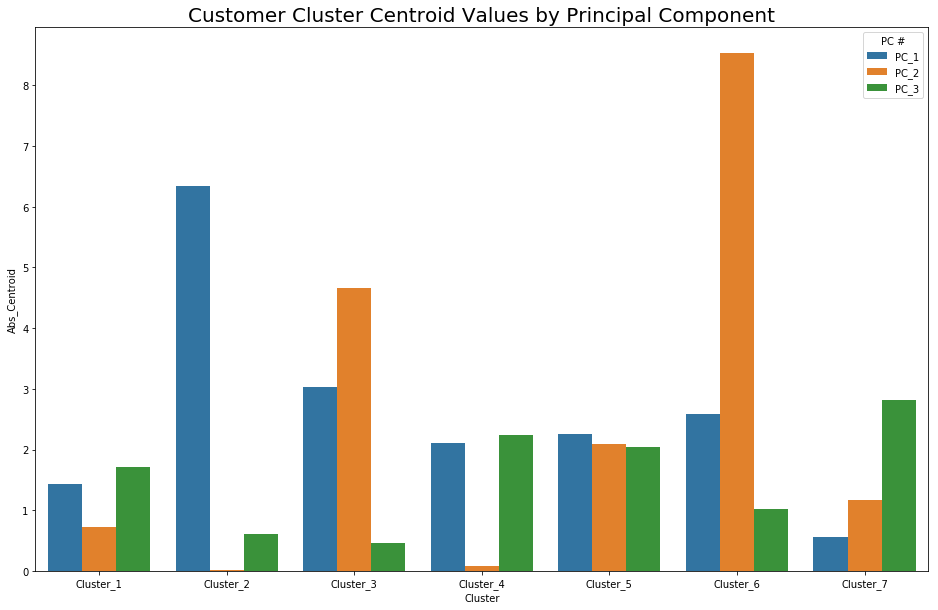

In [190]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
customer_centroids = frame_cluster_centroid(customer_kmeans.cluster_centers_)
plt.figure(figsize=(16, 10))
sns.barplot(x='Cluster', y='Abs_Centroid', hue='PC #', data=customer_centroids)
plt.title('Customer Cluster Centroid Values by Principal Component', size=20)
plt.show()

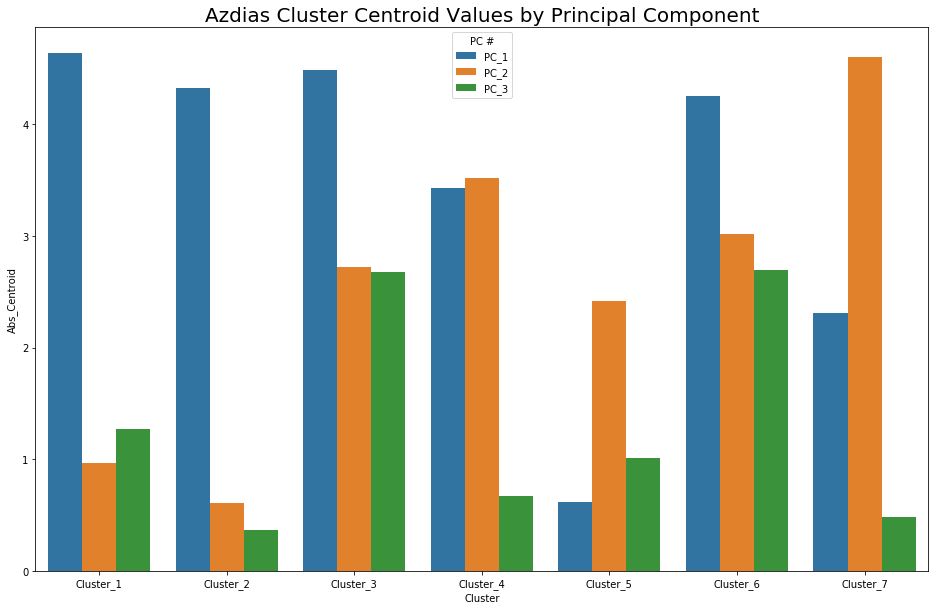

In [191]:
azdias_centroids = frame_cluster_centroid(azdias_kmeans.cluster_centers_)
plt.figure(figsize=(16, 10))
sns.barplot(x='Cluster', y='Abs_Centroid', hue='PC #', data=azdias_centroids)
plt.title('Azdias Cluster Centroid Values by Principal Component', size=20)
plt.show()

In [192]:
display_html('Under-represented Findings:')
key_customer_centroids = get_key_centroids(customer_centroids)
customer_cluster = list(key_customer_centroids.ClusterId)[0]
customer_component = list(key_customer_centroids['PC #'])[0][-1:]
print(f'\t• For customers, we can see that cluster {customer_cluster}'+\
      f" has more weight in the principal component {customer_component}.")

key_azdias_centroids = get_key_centroids(azdias_centroids)
azdias_cluster = list(key_azdias_centroids.ClusterId)[0]
azdias_component = list(key_azdias_centroids['PC #'])[0][-1:]
print(f'\n\t• In contrast, for azdias we can see that cluster {azdias_cluster}'+\
      f" has more weight in the principal component {azdias_component}.")

	• For customers, we can see that cluster 5 has more weight in the principal component 1.

	• In contrast, for azdias we can see that cluster 5 has more weight in the principal component 2.


Theh kind of people that are under-represented in the customer data compare to the general population are  

In [193]:
display_html('Customer Feature Descriptions')
print(f'This subset (cluster {customer_cluster}) is driven mostly by principal component {customer_component}.\n')
get_component_value_key(customer_components, f'Dimension_{customer_component}')

This subset (cluster 5) is driven mostly by principal component 1.



,Features,Dimension_1,Rank,Feat_Key
0,FINANZ_HAUSBAUER,0.19,60,FINANZ_HAUSBAUER
1,MOBI_REGIO,-0.20,1,MOBI_REGIO


,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
317,1.5,1,very high,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,home ownership
293,1.5,2,high,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,home ownership
287,1.5,3,average,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,home ownership
311,1.5,4,low,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,home ownership
299,1.5,5,very low,FINANZ_HAUSBAUER,HAUSBAUER,Financial typology,home ownership
560,7.3,1,very high movement,MOBI_REGIO,REGIO,Movement patterns,NaN
561,7.3,2,high movement,MOBI_REGIO,REGIO,Movement patterns,NaN
562,7.3,3,middle movement,MOBI_REGIO,REGIO,Movement patterns,NaN
563,7.3,4,low movement,MOBI_REGIO,REGIO,Movement patterns,NaN
564,7.3,5,very low movement,MOBI_REGIO,REGIO,Movement patterns,NaN


In [194]:
display_html('Azdias General Feature Description')
print(f'This subset (cluster {azdias_cluster}) is driven mostly by principal component {azdias_component}.\n')
get_component_value_key(azdias_components, f'Dimension_{azdias_component}')

This subset (cluster 5) is driven mostly by principal component 2.



,Features,Dimension_2,Rank,Feat_Key
0,ALTERSKATEGORIE_GROB,0.23,26,ALTERSKATEGORIE_GROB
1,FINANZ_SPARER,-0.23,1,FINANZ_SPARER


,key,value_key,ValueMaps,ColumnName,ColumnShortName,ColNameDescription,ColumnMeta
113,1.2,0,unknown (cannot be determined),ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
114,1.2,1,< 30 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
115,1.2,2,30 - 45 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
116,1.2,3,46 - 60 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
117,1.2,4,> 60 years old,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
118,1.2,9,uniformly distributed,ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
112,1.2,-1,unknown (missing),ALTERSKATEGORIE_GROB,GROB,Estimated age based on given name analysis,NaN
313,1.5,1,very high,FINANZ_SPARER,SPARER,Financial typology,money-saver
289,1.5,2,high,FINANZ_SPARER,SPARER,Financial typology,money-saver
283,1.5,3,average,FINANZ_SPARER,SPARER,Financial typology,money-saver


>**Under-representation conclussions**:

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.